# ABC: Experiments - Policy Evaluation

In this notebook, we compare different policy evaluation results under different configurations for the ABC problem.

The setup was as follows:
  - Different problem sizes (L) were chosen
  - For each problem size, we chose a set of reward periods P
  - L and P make up one configuration
  - For each configuration, we executed 100 runs and computed the mean and std for RMSE and number of steps (for sanity check)
  - For each run, we do 10000 episodes simulating a specific mapping method. We do this for four methods: 
    - identity-mapper: regular policy evaluation with rewards for each step (i.e. P = 1)
    - feedback-only-attribution-mapper: updates the value function only for steps where the cumulative periodic reward is given
    - reward-estimation-ls-mapper: simulate cumulative periodic reward (P > 1), and use least squares to estimate the rewards
    - reward-imputation-mapper: simulate cumuative periodic reward (P > 1), use 0 when rewards are missing
  

In [1]:
from exps import utils
import os.path

In [2]:
import os
import os.path
import json
from typing import Dict, List, Optional, Sequence
import copy
import math

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [4]:
%matplotlib inline

In [5]:
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 30

In [6]:
# Location of logs
LOGS = os.path.join(utils.read_file("exp-abc-eval-cpr_v2-output.txt"), "result-*")
PLOT_SIZE = (40, 10)

## Data Processing

Steps
  - Remove incomplete experiments (didn't reach 10k steps)
  - Remove configs with missing methods (e.g. ls-estimation failed)

In [7]:
df_results = utils.read_experiment_results(LOGS)

In [8]:
df_results

,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable
0,L24-P16,S-M,2260,"{'min': 2283.854745819007, 'max': 2341.9700040...","{'min': 1019.5594, 'max': 1089.3324, 'mean': 1...","{'min': 0.38118094, 'max': 0.47569397, 'mean':...","{'min': -0.20606781869450203, 'max': 0.2379181...","{'min': [[-2987.564453125, -2956.5009765625, -..."
1,L24-P8,ZI-M,6540,"{'min': 58.67342915717897, 'max': 124.96059925...","{'min': 16.829405, 'max': 83.41621, 'mean': 47...","{'min': 0.99931777, 'max': 0.9998484, 'mean': ...","{'min': 0.9983393892926191, 'max': 0.998732082...","{'min': [[-7075.61083984375, -7303.00537109375..."
2,L24-P4,LEAST,4800,"{'min': 483.8966024627575, 'max': 563.67984596...","{'min': 241.20935, 'max': 314.96686, 'mean': 2...","{'min': 0.98798305, 'max': 0.991695, 'mean': 0...","{'min': 0.998919483521123, 'max': 0.9994235171...","{'min': [[-5965.43505859375, -6010.96240234375..."
3,L24-P1,FR,2270,"{'min': 2131.5995167948413, 'max': 2189.736627...","{'min': 1481.259, 'max': 1532.3433, 'mean': 15...","{'min': 0.8423263999999999, 'max': 0.86484796,...","{'min': 0.750956508211658, 'max': 0.9613203658...","{'min': [[-2921.563720703125, -2923.6315917968..."
4,L24-P2,LEAST,4110,"{'min': 830.0895283040257, 'max': 915.88130371...","{'min': 455.95697, 'max': 530.4797, 'mean': 49...","{'min': 0.9694518999999999, 'max': 0.97751653,...","{'min': 0.9891861679667531, 'max': 0.999393570...","{'min': [[-5187.486328125, -5196.77001953125, ..."
...,...,...,...,...,...,...,...,...
444,L16-P4,ZI-M,5380,"{'min': 11.715082108278667, 'max': 33.97177029...","{'min': -8.818337, 'max': 25.629955, 'mean': 7...","{'min': 0.9996653999999999, 'max': 0.99989814,...","{'min': 0.99665694068023, 'max': 0.99779197045...","{'min': [[-2191.7080078125, -2324.75146484375,..."
445,L2-P16,ZI-M,1310,"{'min': 0.572787180630788, 'max': 3.1202382238...","{'min': -0.26663329999999996, 'max': 1.9272976...","{'min': 0.584616, 'max': 0.996091, 'mean': 0.9...","{'min': 0.5882352941176471, 'max': 1.0, 'mean'...","{'min': [[-7.355101108551025, -10.164328575134..."
446,L16-P16,ZI-M,520,"{'min': 983.076834484467, 'max': 1003.70684838...","{'min': 765.1679, 'max': 786.257, 'mean': 773....","{'min': 0.6441498999999999, 'max': 0.7424543, ...","{'min': 0.326426332213612, 'max': 0.7852956683...","{'min': [[-488.1918640136719, -483.63348388671..."
447,L16-P4,ZI-M,9500,"{'min': 11.488698298703506, 'max': 33.59619177...","{'min': -13.686269, 'max': 22.721277, 'mean': ...","{'min': 0.9996231, 'max': 0.9998792400000001, ...","{'min': 0.996431485475436, 'max': 0.9978718937...","{'min': [[-2203.994140625, -2329.649658203125,..."


In [9]:
configs_to_exclude = utils.incomplete_or_missing_results(
    df_results, num_expected_alternatives=None
)

In [10]:
configs_to_exclude

set()

In [11]:
df_filtered_results = utils.filter_configs_from_results(df_results, configs_to_exclude)

In [12]:
df_filtered_results

,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable
0,L24-P16,S-M,2260,"{'min': 2283.854745819007, 'max': 2341.9700040...","{'min': 1019.5594, 'max': 1089.3324, 'mean': 1...","{'min': 0.38118094, 'max': 0.47569397, 'mean':...","{'min': -0.20606781869450203, 'max': 0.2379181...","{'min': [[-2987.564453125, -2956.5009765625, -..."
1,L24-P8,ZI-M,6540,"{'min': 58.67342915717897, 'max': 124.96059925...","{'min': 16.829405, 'max': 83.41621, 'mean': 47...","{'min': 0.99931777, 'max': 0.9998484, 'mean': ...","{'min': 0.9983393892926191, 'max': 0.998732082...","{'min': [[-7075.61083984375, -7303.00537109375..."
2,L24-P4,LEAST,4800,"{'min': 483.8966024627575, 'max': 563.67984596...","{'min': 241.20935, 'max': 314.96686, 'mean': 2...","{'min': 0.98798305, 'max': 0.991695, 'mean': 0...","{'min': 0.998919483521123, 'max': 0.9994235171...","{'min': [[-5965.43505859375, -6010.96240234375..."
3,L24-P1,FR,2270,"{'min': 2131.5995167948413, 'max': 2189.736627...","{'min': 1481.259, 'max': 1532.3433, 'mean': 15...","{'min': 0.8423263999999999, 'max': 0.86484796,...","{'min': 0.750956508211658, 'max': 0.9613203658...","{'min': [[-2921.563720703125, -2923.6315917968..."
4,L24-P2,LEAST,4110,"{'min': 830.0895283040257, 'max': 915.88130371...","{'min': 455.95697, 'max': 530.4797, 'mean': 49...","{'min': 0.9694518999999999, 'max': 0.97751653,...","{'min': 0.9891861679667531, 'max': 0.999393570...","{'min': [[-5187.486328125, -5196.77001953125, ..."
...,...,...,...,...,...,...,...,...
444,L16-P4,ZI-M,5380,"{'min': 11.715082108278667, 'max': 33.97177029...","{'min': -8.818337, 'max': 25.629955, 'mean': 7...","{'min': 0.9996653999999999, 'max': 0.99989814,...","{'min': 0.99665694068023, 'max': 0.99779197045...","{'min': [[-2191.7080078125, -2324.75146484375,..."
445,L2-P16,ZI-M,1310,"{'min': 0.572787180630788, 'max': 3.1202382238...","{'min': -0.26663329999999996, 'max': 1.9272976...","{'min': 0.584616, 'max': 0.996091, 'mean': 0.9...","{'min': 0.5882352941176471, 'max': 1.0, 'mean'...","{'min': [[-7.355101108551025, -10.164328575134..."
446,L16-P16,ZI-M,520,"{'min': 983.076834484467, 'max': 1003.70684838...","{'min': 765.1679, 'max': 786.257, 'mean': 773....","{'min': 0.6441498999999999, 'max': 0.7424543, ...","{'min': 0.326426332213612, 'max': 0.7852956683...","{'min': [[-488.1918640136719, -483.63348388671..."
447,L16-P4,ZI-M,9500,"{'min': 11.488698298703506, 'max': 33.59619177...","{'min': -13.686269, 'max': 22.721277, 'mean': ...","{'min': 0.9996231, 'max': 0.9998792400000001, ...","{'min': 0.996431485475436, 'max': 0.9978718937...","{'min': [[-2203.994140625, -2329.649658203125,..."


## Overview

Let's try and plot of the results to see what we get.

In [13]:
utils.slice_config(df_filtered_results, "L2-P2")

,index,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable
0,442,L2-P2,LEAST,0,"{'min': 5.099019513592784, 'max': 5.0990195135...","{'min': 3.6666667, 'max': 3.6666667, 'mean': 3...","{'min': None, 'max': None, 'mean': None, 'std'...","{'min': 0.0, 'max': 0.0, 'mean': 0.0, 'std': 0.0}","{'min': [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], ..."
1,240,L2-P2,S-M,0,"{'min': 4.4627421081004774, 'max': 5.099019513...","{'min': 3.17, 'max': 3.6666667, 'mean': 3.5846...","{'min': None, 'max': None, 'mean': None, 'std'...","{'min': 0.0, 'max': 0.8932596002688611, 'mean'...","{'min': [[-0.300000011920928, -1.6000000238418..."
2,497,L2-P2,ZI-M,0,"{'min': 4.598470740501141, 'max': 5.0931326837...","{'min': 3.1900003, 'max': 3.6333332, 'mean': 3...","{'min': -0.3365625, 'max': 0.88681877, 'mean':...","{'min': -0.132842232831014, 'max': 0.893259600...","{'min': [[-0.300000011920928, -1.0800000429153..."
3,363,L2-P2,LEAST,10,"{'min': 3.30803451405686, 'max': 4.81044755245...","{'min': 2.233516, 'max': 3.4233332, 'mean': 2....","{'min': 0.4366229, 'max': 0.9829635, 'mean': 0...","{'min': 0.40042671736190305, 'max': 1.0, 'mean...","{'min': [[-1.7450246810913081, -3.413092374801..."
4,95,L2-P2,S-M,10,"{'min': 3.155059438831705, 'max': 4.6339887955...","{'min': 2.0567377, 'max': 3.304807, 'mean': 2....","{'min': 0.48609617, 'max': 0.9923875999999999,...","{'min': 0.44589632137052204, 'max': 0.95486371...","{'min': [[-2.495298147201538, -4.4398622512817..."
...,...,...,...,...,...,...,...,...,...
2995,43,L2-P2,ZI-M,9980,"{'min': 0.21367404002151003, 'max': 1.49242491...","{'min': -0.7211613, 'max': 0.8113243, 'mean': ...","{'min': 0.94129556, 'max': 0.99878776, 'mean':...","{'min': 0.9411764705882351, 'max': 1.0, 'mean'...","{'min': [[-7.047780036926269, -10.007061958312..."
2996,104,L2-P2,LEAST,9980,"{'min': 0.051246317649036005, 'max': 2.0558713...","{'min': -0.7863715, 'max': 1.5105095, 'mean': ...","{'min': 0.9670486500000001, 'max': 0.99990004,...","{'min': 0.9411764705882351, 'max': 1.0, 'mean'...","{'min': [[-6.545207977294922, -10.479068756103..."
2997,205,L2-P2,LEAST,9990,"{'min': 0.078956385420602, 'max': 2.1054909444...","{'min': -0.76390773, 'max': 1.5552751, 'mean':...","{'min': 0.9646032999999999, 'max': 0.999871699...","{'min': 0.9411764705882351, 'max': 1.0, 'mean'...","{'min': [[-6.936437129974365, -11.098628044128..."
2998,482,L2-P2,S-M,9990,"{'min': 0.7351566780891751, 'max': 3.873712141...","{'min': -2.4203918, 'max': -0.09764703, 'mean'...","{'min': 0.9593957, 'max': 0.9955634999999999, ...","{'min': 0.8932596002688611, 'max': 0.954863710...","{'min': [[-10.241868019104004, -15.67544269561..."


In [14]:
utils.slice_config(df_filtered_results, "L2-P2").iloc[0, :]["rmse"]

{'min': 5.099019513592784,
 'max': 5.099019513592784,
 'mean': 5.099019513592786,
 'std': 1.7853057969915872e-15}

<AxesSubplot:title={'center':'Level=2,P=2'}, xlabel='Episode', ylabel='mean_error'>

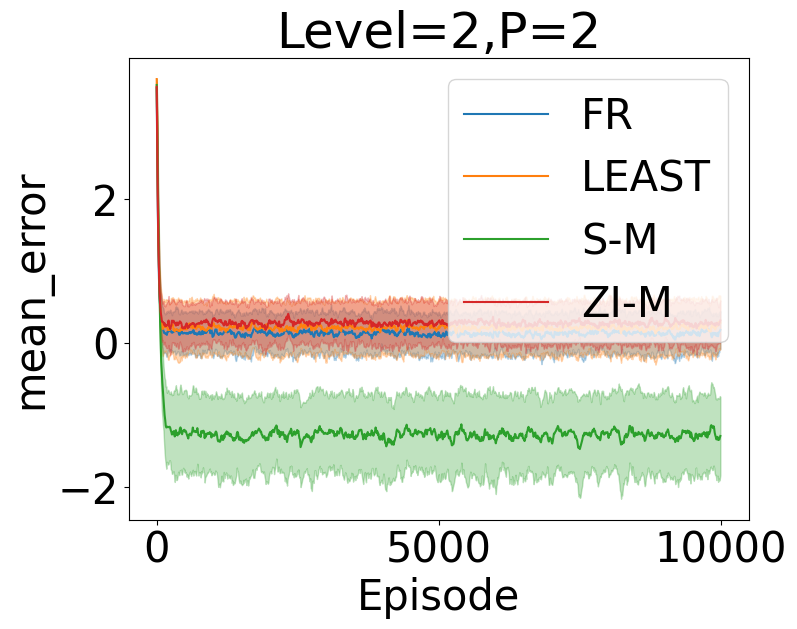

In [15]:
#  colors=["slategray", "purple", "turquoise", "orange"]
utils.plot_config_comparison(df_filtered_results, "L2-P2", metric="mean_error")

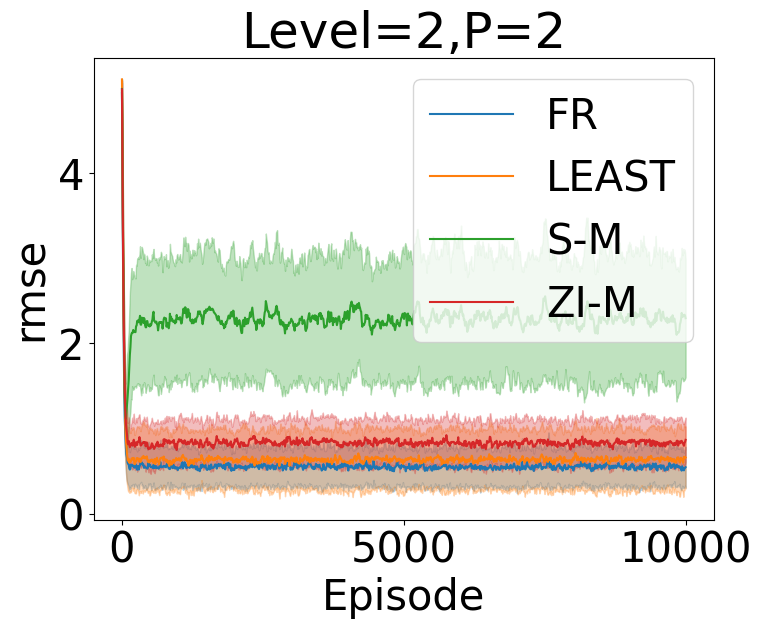

In [16]:
# place in fn; export all graphs to the a dir as pdf
# insert into report
# start writing like a mad man
# create a fn to take ax, plot and save
# use the same x-axis on plots to keep them aligned (see diff)
# rename labels
utils.plot_config_comparison(df_filtered_results, "L2-P2").plot()
plt.savefig("image.pdf", dpi=300, format="pdf", transparent=True)

<AxesSubplot:title={'center':'Level=8,P=4'}, xlabel='Episode', ylabel='rmse'>

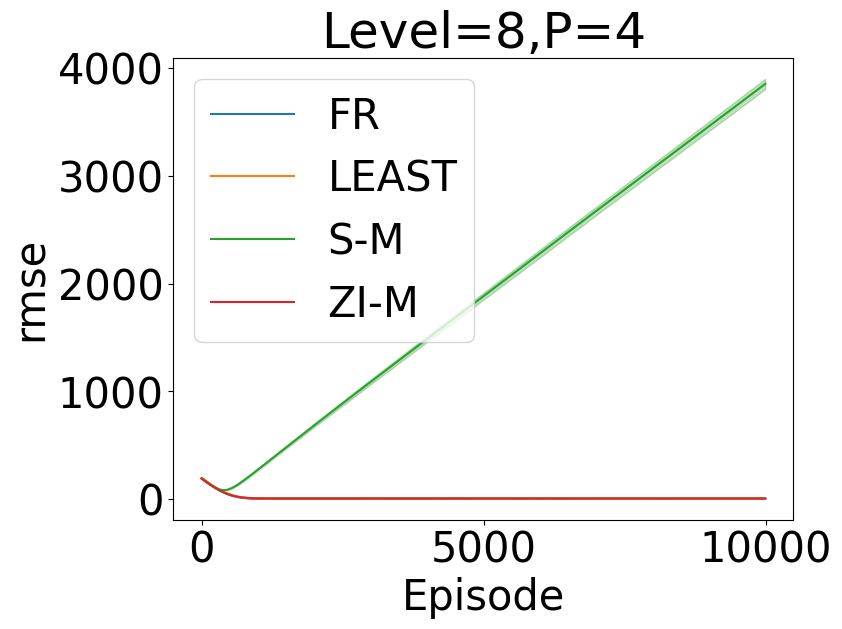

In [17]:
utils.plot_config_comparison(df_filtered_results, "L8-P4")

We can make it easier to filter by a problem or reward period P.

In [18]:
df_final = utils.expand_for_lookup(df_filtered_results)

In [19]:
df_final.sort_values(by=["P", "L"])

,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable,L,P
48,L16-P1,FR,8050,"{'min': 10.82298097172206, 'max': 33.848617133...","{'min': -5.6414886, 'max': 24.103647, 'mean': ...","{'min': 0.9995980999999999, 'max': 0.999894699...","{'min': 0.997985814215368, 'max': 0.9986836517...","{'min': [[-2203.077880859375, -2337.0390625, -...",16,1
64,L16-P1,FR,6880,"{'min': 11.455133904648932, 'max': 32.61233777...","{'min': -11.760781, 'max': 26.447666, 'mean': ...","{'min': 0.99953914, 'max': 0.99989176, 'mean':...","{'min': 0.9979613600793981, 'max': 0.998689616...","{'min': [[-2198.7236328125, -2328.874755859375...",16,1
107,L16-P1,FR,2350,"{'min': 109.02194356957456, 'max': 139.9809906...","{'min': 52.163177, 'max': 89.28595, 'mean': 69...","{'min': 0.99323773, 'max': 0.9965725999999999,...","{'min': 0.998156396724815, 'max': 0.9989741191...","{'min': [[-1937.84423828125, -1990.48120117187...",16,1
112,L16-P1,FR,5360,"{'min': 11.132333117420043, 'max': 31.36876358...","{'min': -14.0731125, 'max': 23.055883, 'mean':...","{'min': 0.9996517300000001, 'max': 0.9999077, ...","{'min': 0.997953009886628, 'max': 0.9987110881...","{'min': [[-2192.58935546875, -2321.84814453125...",16,1
126,L16-P1,FR,6800,"{'min': 10.31659852859436, 'max': 33.209594957...","{'min': -10.886954, 'max': 27.025858, 'mean': ...","{'min': 0.9995875, 'max': 0.999899, 'mean': 0....","{'min': 0.9979589743100351, 'max': 0.998700352...","{'min': [[-2192.67529296875, -2333.23486328125...",16,1
...,...,...,...,...,...,...,...,...,...,...
367,L8-P16,S-M,2610,"{'min': 681.0380633635685, 'max': 744.30823588...","{'min': -655.4768, 'max': -597.4423, 'mean': -...","{'min': 0.92724335, 'max': 0.9603398400000001,...","{'min': 0.9287210104516471, 'max': 0.990401690...","{'min': [[-1223.113037109375, -1240.4403076171...",8,16
369,L8-P16,ZI-M,4250,"{'min': 5.490999834079076, 'max': 14.020272971...","{'min': -1.9217712, 'max': 11.125519, 'mean': ...","{'min': 0.9961635999999999, 'max': 0.998788540...","{'min': 0.986669242658423, 'max': 0.9938820195...","{'min': [[-290.88641357421875, -332.6651916503...",8,16
376,L8-P16,LEAST,6310,"{'min': 3.456881865813741, 'max': 10.828782715...","{'min': -5.7405086, 'max': 7.6236286, 'mean': ...","{'min': 0.9980173999999999, 'max': 0.9994883, ...","{'min': 0.9931092220504891, 'max': 0.997585007...","{'min': [[-296.0115051269531, -327.76092529296...",8,16
382,L8-P16,ZI-M,9210,"{'min': 4.943616916876266, 'max': 16.487044363...","{'min': -1.1610789, 'max': 11.017426, 'mean': ...","{'min': 0.99530935, 'max': 0.9988484999999999,...","{'min': 0.9869268418341061, 'max': 0.992658423...","{'min': [[-300.8284912109375, -329.92306518554...",8,16


In [20]:
sorted(df_final[df_final["P"] > 1]["P"].unique())

[2, 4, 8, 16]

**Results Tables**

In [21]:
utils.table_config_comparison(df_final, "L8-P4")

,config,method,episode,rmse ± std,rmse (mean),rmse (std)
999,L8-P4,FR,9990,6.322±1.652,6.322,1.652
2999,L8-P4,LEAST,9990,5.854±1.429,5.854,1.429
2998,L8-P4,S-M,9990,3852.374±47.991,3852.374,47.991
2997,L8-P4,ZI-M,9990,6.494±1.366,6.494,1.366


In [22]:
df_final[["L", "P"]].drop_duplicates().sort_values(by=["L", "P"])

,L,P
48,16,1
8,16,2
10,16,4
14,16,8
6,16,16
43,2,1
7,2,2
32,2,4
11,2,8
9,2,16


In [23]:
df_final[(df_final["L"] == "8") & (df_final["P"] == 2)]

,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable,L,P
34,L8-P2,LEAST,4320,"{'min': 3.732390191519108, 'max': 10.030034927...","{'min': -5.306696, 'max': 8.0586815, 'mean': 1...","{'min': 0.99761665, 'max': 0.99954075, 'mean':...","{'min': 0.993399021123132, 'max': 0.9981002060...","{'min': [[-290.69256591796875, -326.12109375, ...",8,2
41,L8-P2,S-M,8470,"{'min': 170.66265610115178, 'max': 201.9842873...","{'min': -170.89215, 'max': -141.91045, 'mean':...","{'min': 0.99760824, 'max': 0.9994953999999999,...","{'min': 0.9898863430051491, 'max': 0.996134934...","{'min': [[-579.0022583007812, -660.21704101562...",8,2
42,L8-P2,S-M,3950,"{'min': 164.29715361959256, 'max': 202.5726721...","{'min': -169.29454, 'max': -139.04338, 'mean':...","{'min': 0.99741167, 'max': 0.9994814, 'mean': ...","{'min': 0.9895642506799601, 'max': 0.996038306...","{'min': [[-582.7803344726562, -666.14202880859...",8,2
54,L8-P2,LEAST,7620,"{'min': 3.904004970093987, 'max': 11.049897510...","{'min': -5.6533513, 'max': 8.482661, 'mean': 2...","{'min': 0.99641174, 'max': 0.99954635, 'mean':...","{'min': 0.993592220504894, 'max': 0.9974562081...","{'min': [[-292.3942565917969, -330.83438110351...",8,2
58,L8-P2,LEAST,5670,"{'min': 3.431079347462898, 'max': 11.462106386...","{'min': -4.3444347, 'max': 8.61093, 'mean': 2....","{'min': 0.9980525, 'max': 0.9995094999999999, ...","{'min': 0.9936888201957751, 'max': 0.997520607...","{'min': [[-292.985595703125, -329.563842773437...",8,2
...,...,...,...,...,...,...,...,...,...,...
387,L8-P2,LEAST,9790,"{'min': 3.56710718292568, 'max': 12.9123591634...","{'min': -2.5446332, 'max': 9.470881, 'mean': 2...","{'min': 0.9977672, 'max': 0.9994535999999999, ...","{'min': 0.991885625965996, 'max': 0.9975206079...","{'min': [[-292.8961486816406, -331.89837646484...",8,2
390,L8-P2,LEAST,8280,"{'min': 3.086527089642606, 'max': 12.635102413...","{'min': -3.9837214999999997, 'max': 10.089802,...","{'min': 0.99777716, 'max': 0.9995567999999999,...","{'min': 0.9932702215352911, 'max': 0.997874806...","{'min': [[-291.9457702636719, -330.15054321289...",8,2
417,L8-P2,S-M,7840,"{'min': 169.17058120983978, 'max': 200.7525684...","{'min': -171.70866, 'max': -139.29272, 'mean':...","{'min': 0.9978424300000001, 'max': 0.999364599...","{'min': 0.9903050630278961, 'max': 0.996038306...","{'min': [[-585.5836791992188, -664.95916748046...",8,2
428,L8-P2,ZI-M,400,"{'min': 54.85108124076726, 'max': 67.211372938...","{'min': 33.943985, 'max': 45.09609, 'mean': 40...","{'min': 0.9241442, 'max': 0.9771285999999999, ...","{'min': 0.8750000000000001, 'max': 0.995492014...","{'min': [[-193.3956298828125, -195.53836059570...",8,2


**Experiments**

In [24]:
experiments = utils.get_experiment_configs(df_final)

In [25]:
experiments

{'16': [1, 2, 4, 8, 16],
 '2': [1, 2, 4, 8, 16],
 '24': [1, 2, 4, 8, 16],
 '8': [1, 2, 4, 8, 16]}

In [26]:
sorted(experiments.items(), key=lambda kv: int(kv[0]))

[('2', [1, 2, 4, 8, 16]),
 ('8', [1, 2, 4, 8, 16]),
 ('16', [1, 2, 4, 8, 16]),
 ('24', [1, 2, 4, 8, 16])]

## Fix problem, increase reward period

In [27]:
utils.get_configs(df_final, level="2", exclude_baseline=True)

['L2-P2', 'L2-P4', 'L2-P8', 'L2-P16']

In [28]:
df_final["L"].unique()

array(['24', '16', '2', '8'], dtype=object)

### ABC L=2


In [29]:
utils.get_configs(df_final, level="2")

['L2-P2', 'L2-P4', 'L2-P8', 'L2-P16']

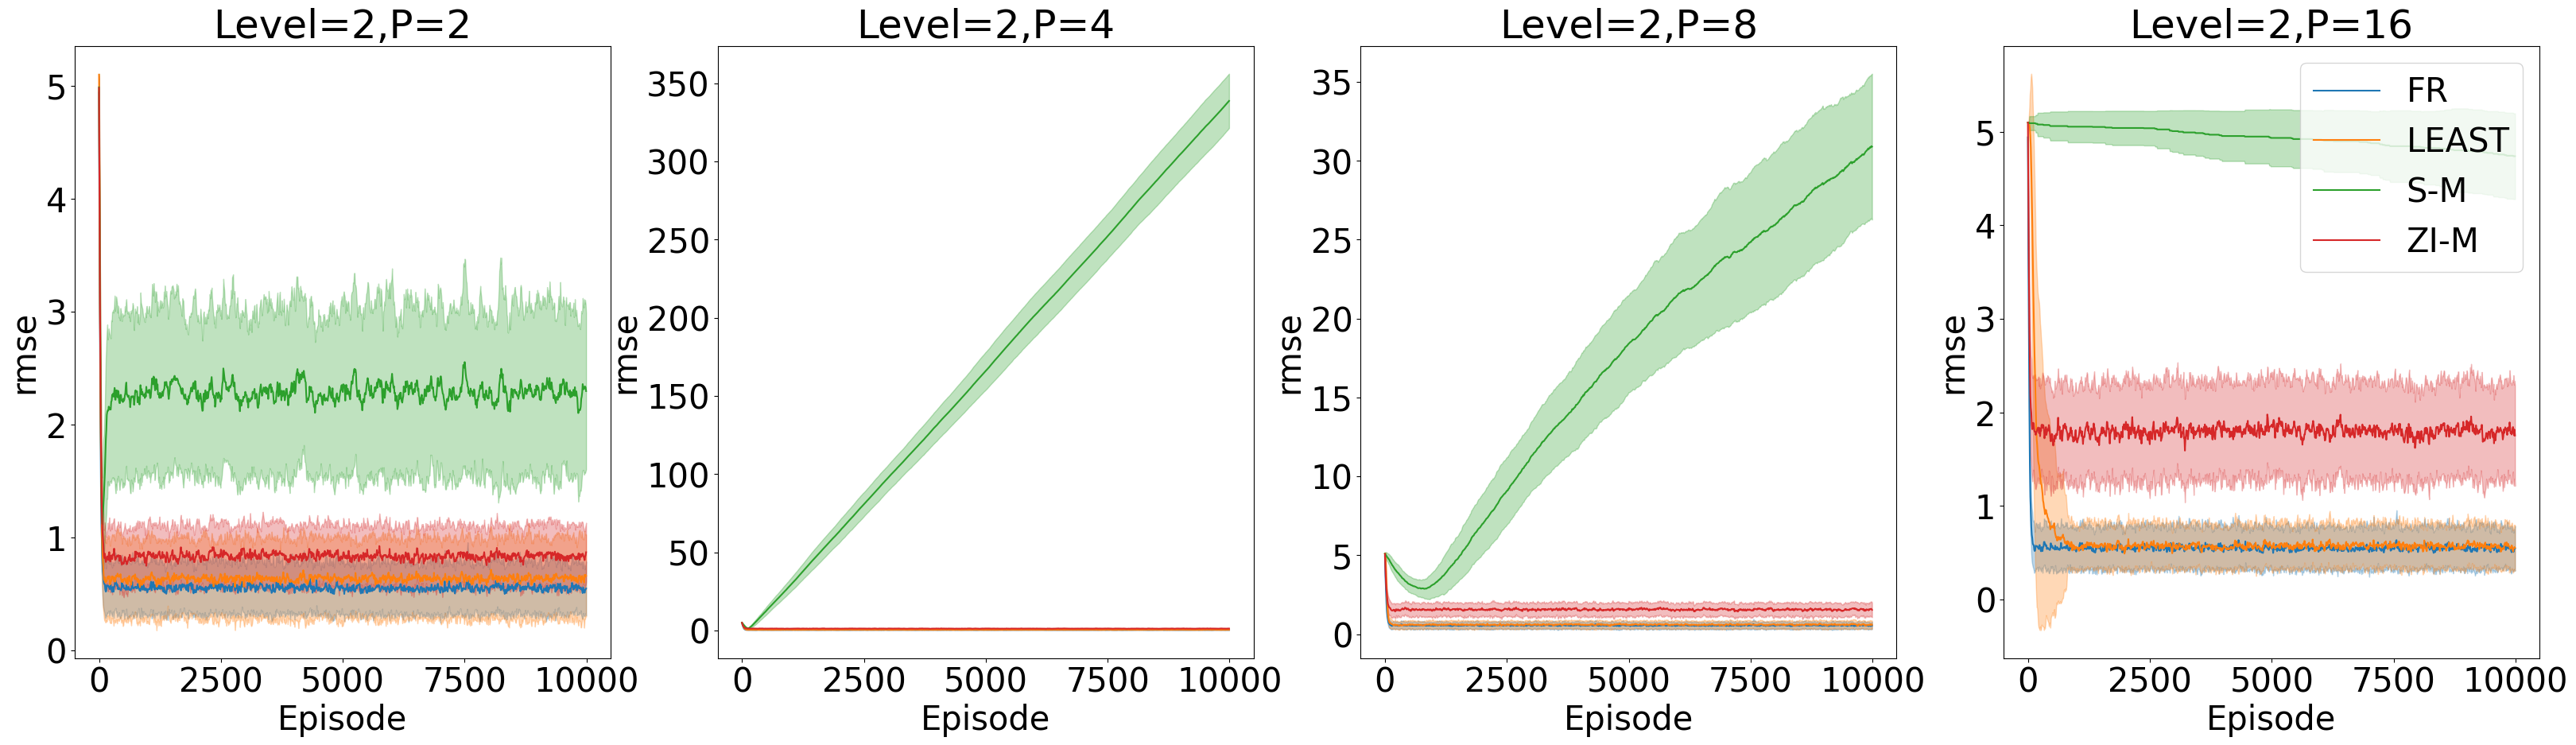

In [30]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="2"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_fixed_L2_change_Pxx", format="pdf")

# skip-missing: S, A, x, S, A, x, S, A, CR
# zero-impute: S, A, 0, S, A, 0, S, A, CR
# estimation: S, A, R^, S, A, R^, S, A, R^
# Q(s,a)
# People estimate V(s) instead of Q(s,a)?

#  S: 1, 2, 3, 4, 5, 6 - cannot be solved
#     1, 1, 1, 0, 0, 0
#     0, 0, 0, 1, 1, 1
# under which conditions does it converge and fail to converge

In [31]:
utils.combine_table_config_comparisons(
    df_final, configs=utils.get_configs(df_final, level="2")
)

,config,method,episode,rmse ± std,rmse (mean),rmse (std)
999,L2-P2,FR,9990,0.547±0.239,0.547,0.239
2997,L2-P2,LEAST,9990,0.66±0.363,0.66,0.363
2998,L2-P2,S-M,9990,2.295±0.693,2.295,0.693
2999,L2-P2,ZI-M,9990,0.868±0.261,0.868,0.261
999,L2-P4,FR,9990,0.547±0.239,0.547,0.239
2998,L2-P4,LEAST,9990,0.628±0.348,0.628,0.348
2997,L2-P4,S-M,9990,338.649±17.374,338.649,17.374
2999,L2-P4,ZI-M,9990,1.319±0.399,1.319,0.399
999,L2-P8,FR,9990,0.547±0.239,0.547,0.239
2997,L2-P8,LEAST,9990,0.595±0.252,0.595,0.252


### ABC L=8


In [32]:
utils.get_configs(df_final, level="8")

['L8-P2', 'L8-P4', 'L8-P8', 'L8-P16']

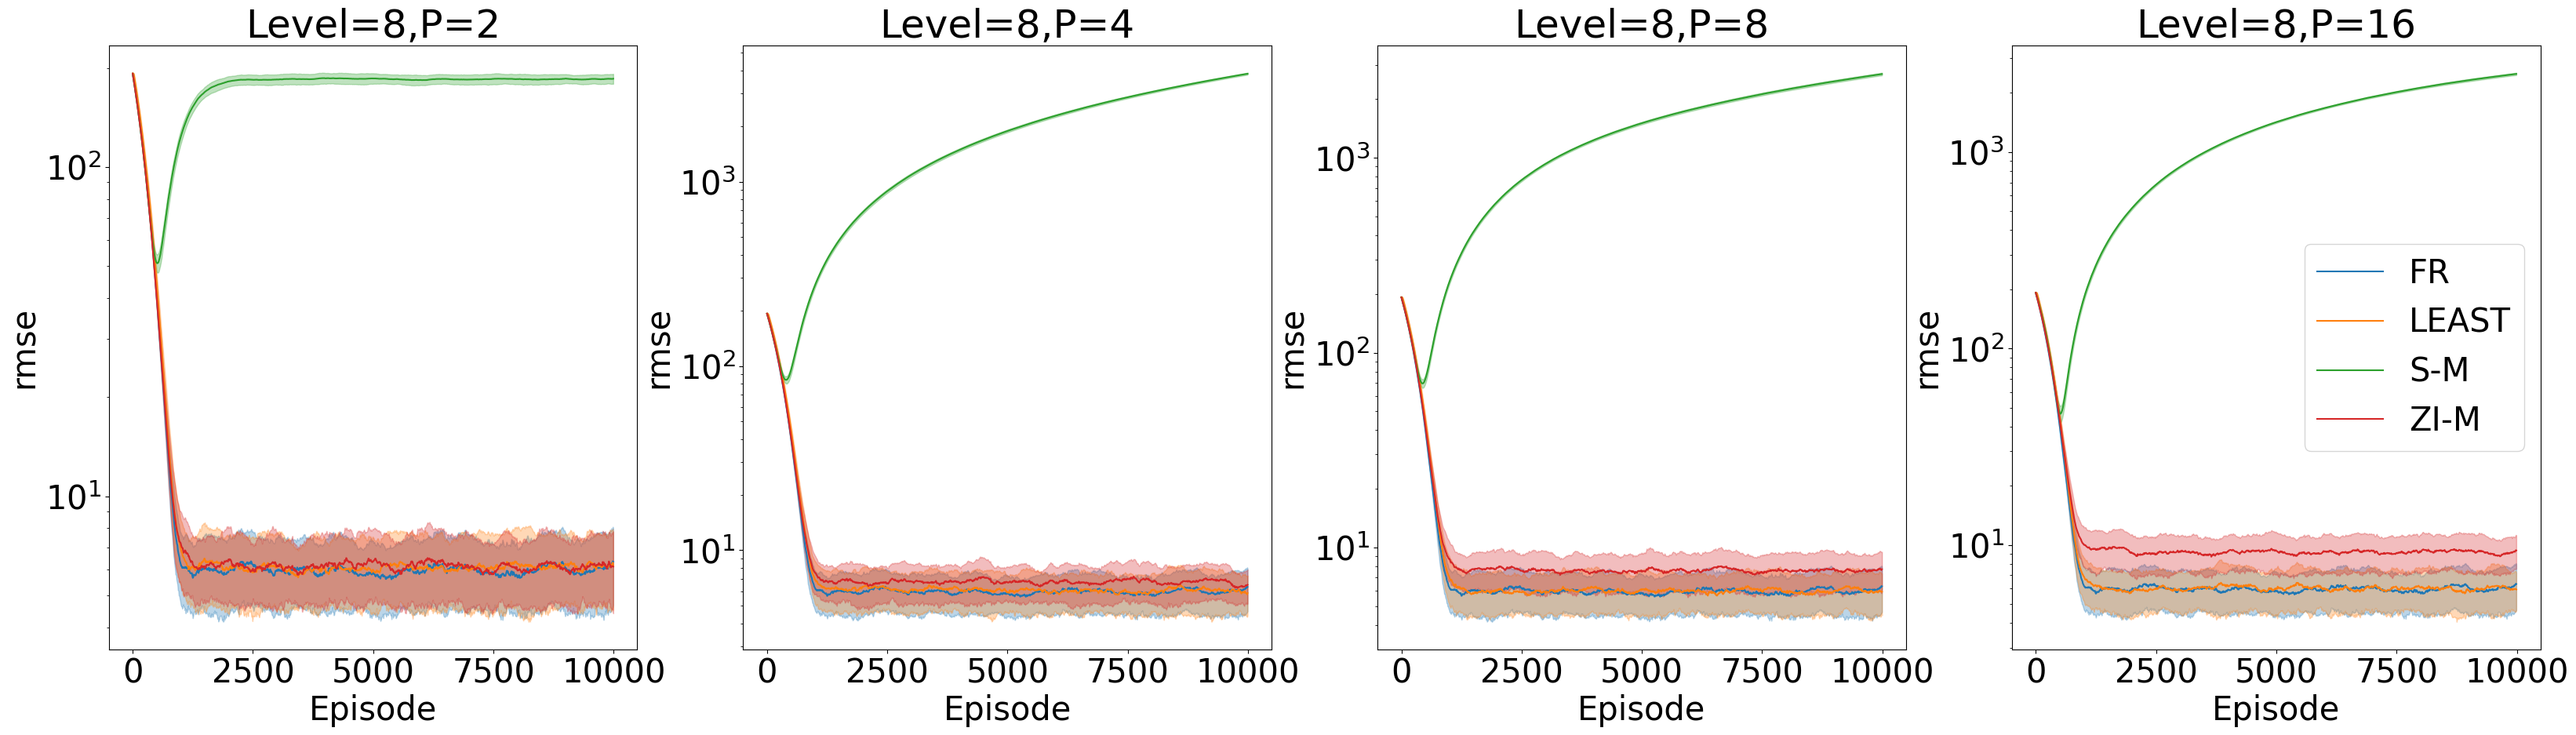

In [33]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="8"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_fixed_L8_change_Pxx", format="pdf")

In [34]:
utils.combine_table_config_comparisons(
    df_final, configs=utils.get_configs(df_final, level="8")
)

,config,method,episode,rmse ± std,rmse (mean),rmse (std)
999,L8-P2,FR,9990,6.322±1.652,6.322,1.652
2997,L8-P2,LEAST,9990,6.147±1.638,6.147,1.638
2998,L8-P2,S-M,9990,185.377±6.437,185.377,6.437
2999,L8-P2,ZI-M,9990,6.111±1.704,6.111,1.704
999,L8-P4,FR,9990,6.322±1.652,6.322,1.652
2999,L8-P4,LEAST,9990,5.854±1.429,5.854,1.429
2998,L8-P4,S-M,9990,3852.374±47.991,3852.374,47.991
2997,L8-P4,ZI-M,9990,6.494±1.366,6.494,1.366
999,L8-P8,FR,9990,6.322±1.652,6.322,1.652
2999,L8-P8,LEAST,9990,5.927±1.436,5.927,1.436


### ABC L=16

In [35]:
utils.get_configs(df_final, level="16")

['L16-P2', 'L16-P4', 'L16-P8', 'L16-P16']

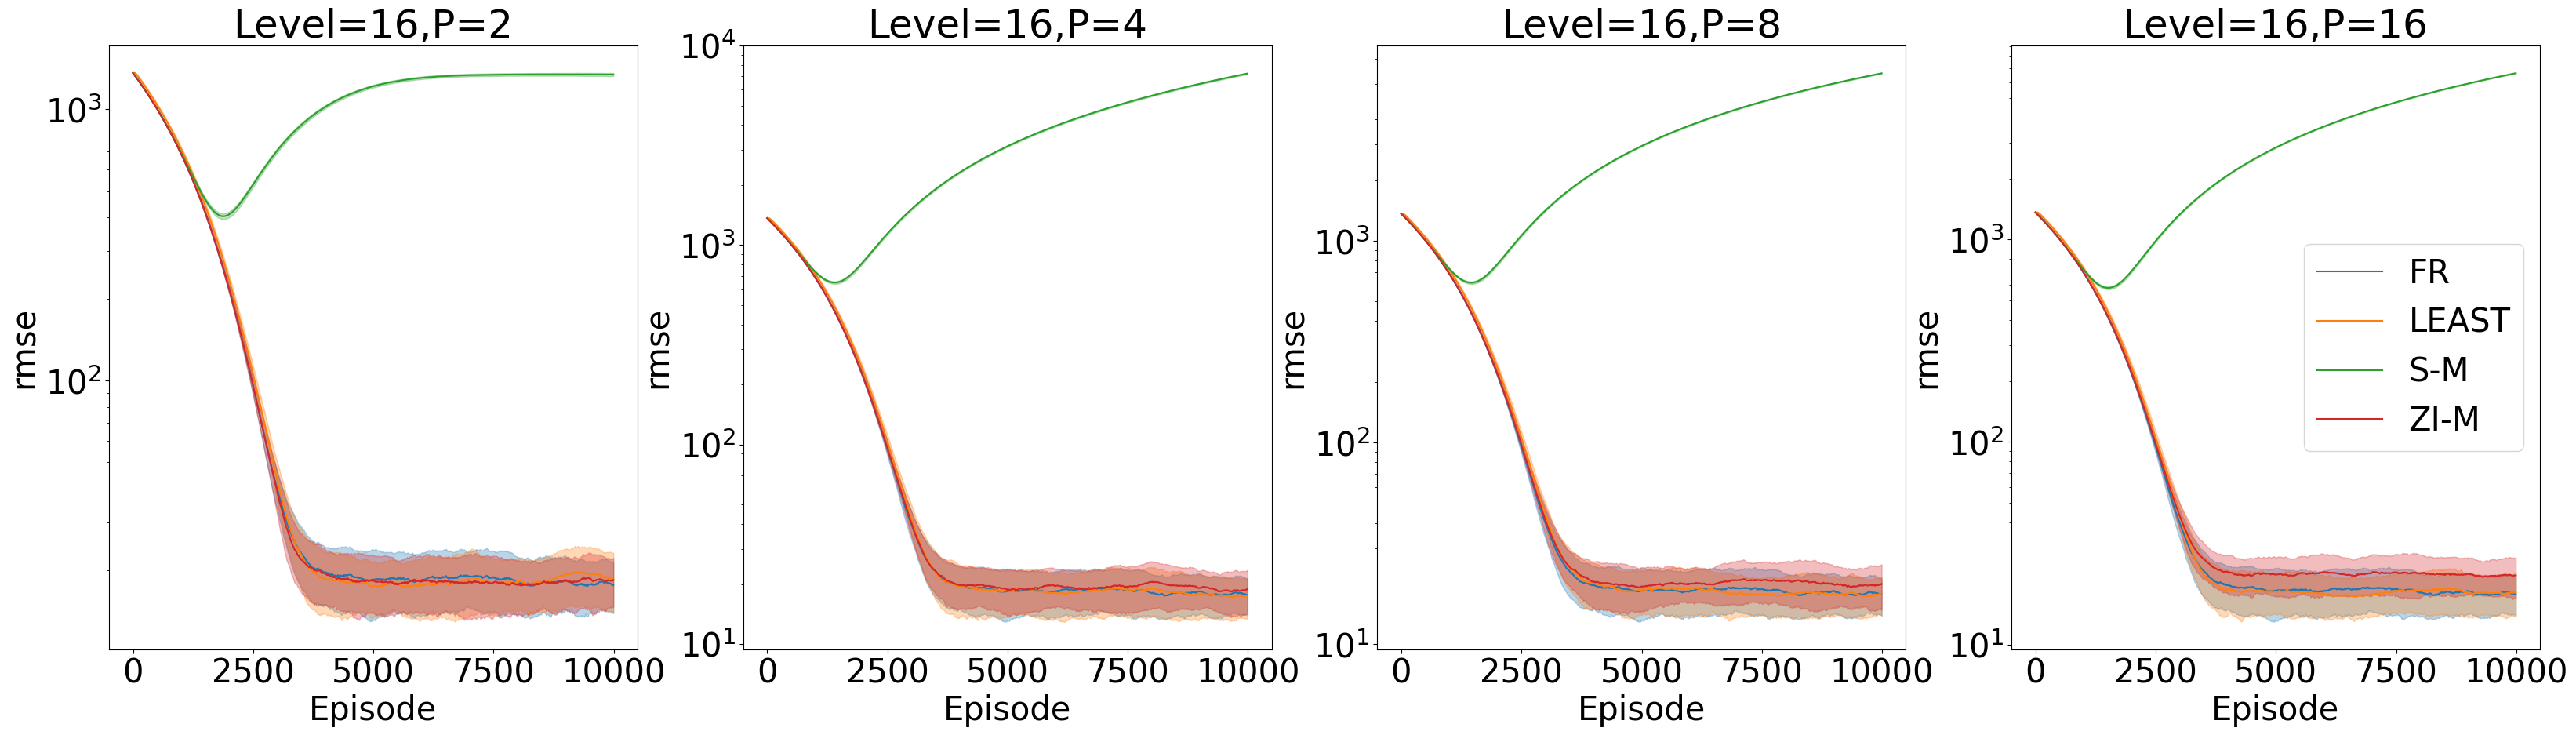

In [36]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="16"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_fixed_L16_change_Pxx", format="pdf")

In [37]:
utils.combine_table_config_comparisons(
    df_final, configs=utils.get_configs(df_final, level="16")
)

,config,method,episode,rmse ± std,rmse (mean),rmse (std)
999,L16-P2,FR,9990,17.593±3.736,17.593,3.736
2999,L16-P2,LEAST,9990,18.578±4.647,18.578,4.647
2997,L16-P2,S-M,9990,1344.72±17.973,1344.72,17.973
2998,L16-P2,ZI-M,9990,18.411±3.79,18.411,3.79
999,L16-P4,FR,9990,17.593±3.736,17.593,3.736
2999,L16-P4,LEAST,9990,17.406±4.026,17.406,4.026
2998,L16-P4,S-M,9990,7238.37±59.674,7238.37,59.674
2997,L16-P4,ZI-M,9990,18.806±4.431,18.806,4.431
999,L16-P8,FR,9990,17.593±3.736,17.593,3.736
2997,L16-P8,LEAST,9990,17.46±3.539,17.46,3.539


### ABC L=24

In [38]:
utils.get_configs(df_final, level="24")

['L24-P2', 'L24-P4', 'L24-P8', 'L24-P16']

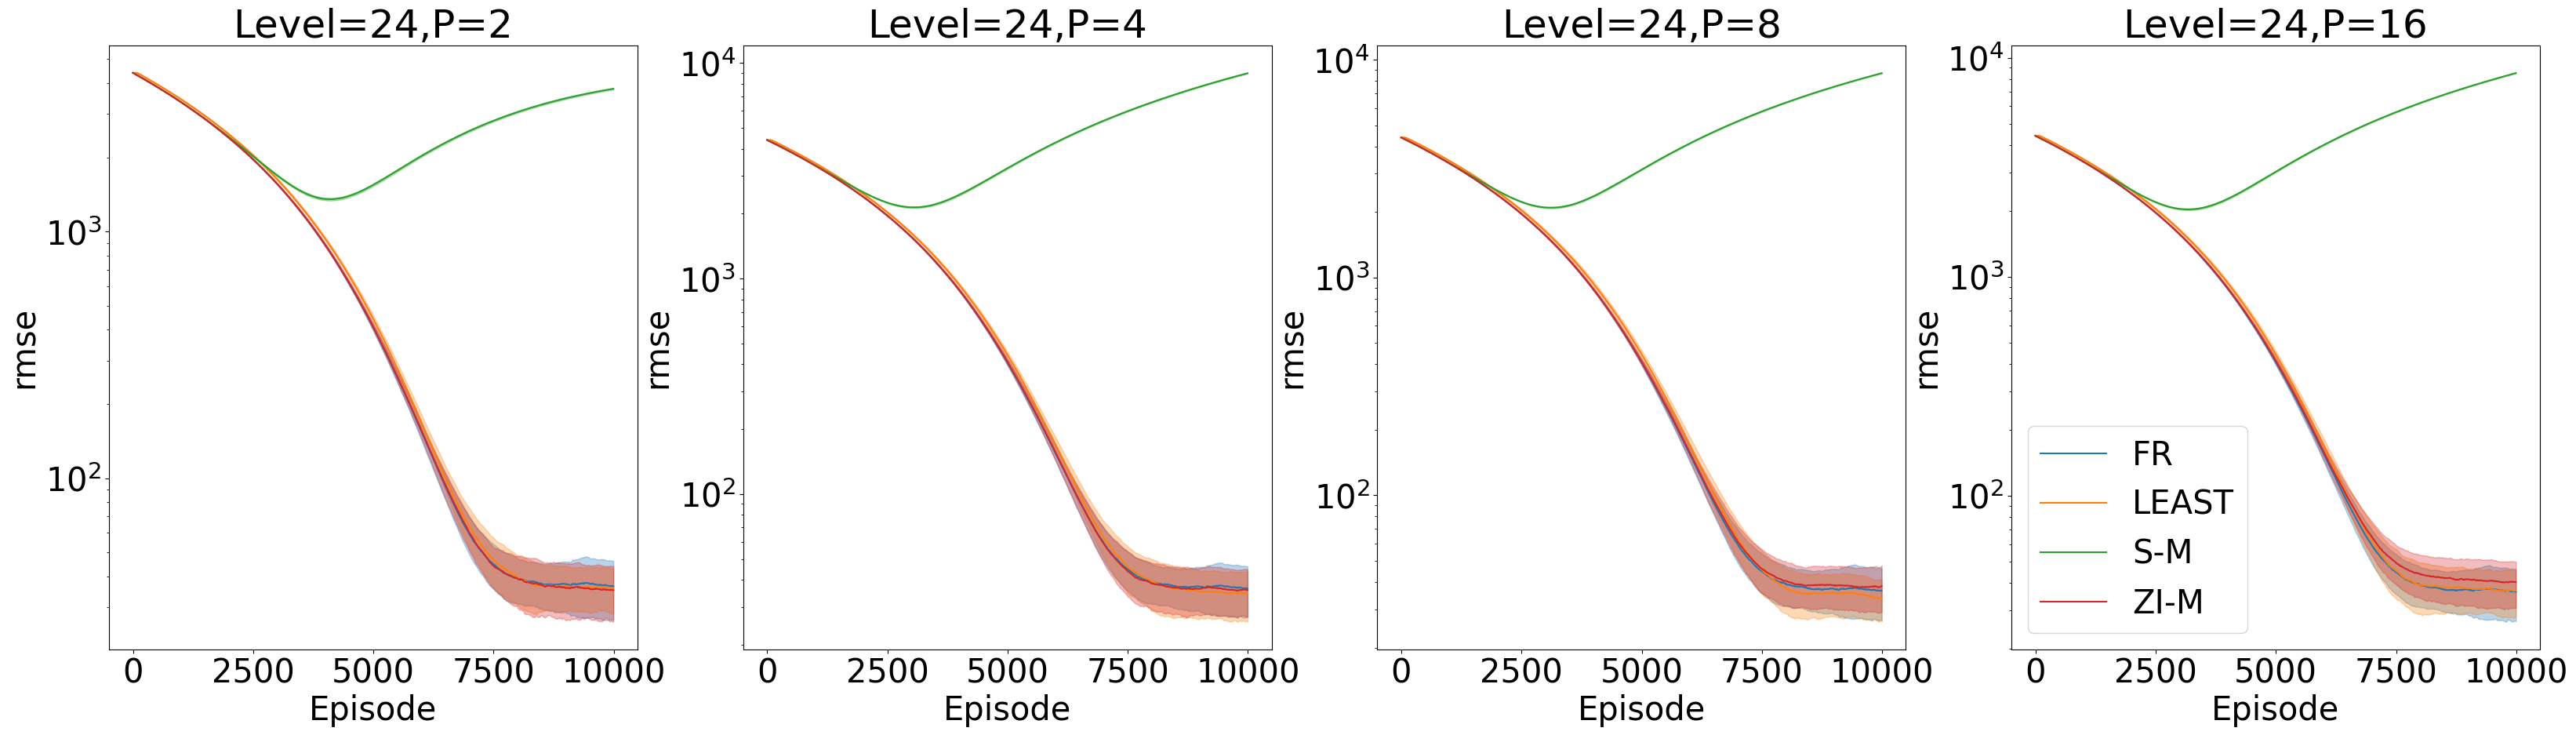

In [39]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="24"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_fixed_L24_change_Pxx", format="pdf")

In [40]:
utils.combine_table_config_comparisons(
    df_final, configs=utils.get_configs(df_final, level="24")
)

,config,method,episode,rmse ± std,rmse (mean),rmse (std)
999,L24-P2,FR,9990,36.421±9.763,36.421,9.763
2999,L24-P2,LEAST,9990,35.84±7.414,35.84,7.414
2998,L24-P2,S-M,9990,3791.951±30.037,3791.951,30.037
2997,L24-P2,ZI-M,9990,35.215±8.889,35.215,8.889
999,L24-P4,FR,9990,36.421±9.763,36.421,9.763
2998,L24-P4,LEAST,9990,34.621±9.044,34.621,9.044
2997,L24-P4,S-M,9990,8978.408±47.414,8978.408,47.414
2999,L24-P4,ZI-M,9990,35.883±8.86,35.883,8.86
999,L24-P8,FR,9990,36.421±9.763,36.421,9.763
2997,L24-P8,LEAST,9990,33.698±7.316,33.698,7.316


In [41]:
import imp

imp.reload(utils)

<module 'exps.utils' from '/Users/guilherme/Code/rl-daaf/notebooks/daaf/onpolicy_eval/exps/utils.py'>

In [42]:
print(
    utils.df_final_print(
        utils.combine_table_config_comparisons(
            df_final, configs=["L2-P2", "L8-P2", "L16-P2", "L24-P2"]
        ),
        metric="rmse",
    ).to_latex(index=False)
)

\begin{tabular}{lrll}
\toprule
Level &  P & Method &      rmse ± std \\
\midrule
    2 &  2 &     FR &     0.547±0.239 \\
    2 &  2 &  LEAST &      0.66±0.363 \\
    2 &  2 &    S-M &     2.295±0.693 \\
    2 &  2 &   ZI-M &     0.868±0.261 \\
    8 &  2 &     FR &     6.322±1.652 \\
    8 &  2 &  LEAST &     6.147±1.638 \\
    8 &  2 &    S-M &   185.377±6.437 \\
    8 &  2 &   ZI-M &     6.111±1.704 \\
   16 &  2 &     FR &    17.593±3.736 \\
   16 &  2 &  LEAST &    18.578±4.647 \\
   16 &  2 &    S-M &  1344.72±17.973 \\
   16 &  2 &   ZI-M &     18.411±3.79 \\
   24 &  2 &     FR &    36.421±9.763 \\
   24 &  2 &  LEAST &     35.84±7.414 \\
   24 &  2 &    S-M & 3791.951±30.037 \\
   24 &  2 &   ZI-M &    35.215±8.889 \\
\bottomrule
\end{tabular}



/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_30776/372597573.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.df_final_print(utils.combine_table_config_comparisons(df_final, configs=["L2-P2", "L8-P2", "L16-P2", "L24-P2"]), metric="rmse").to_latex(index=False))


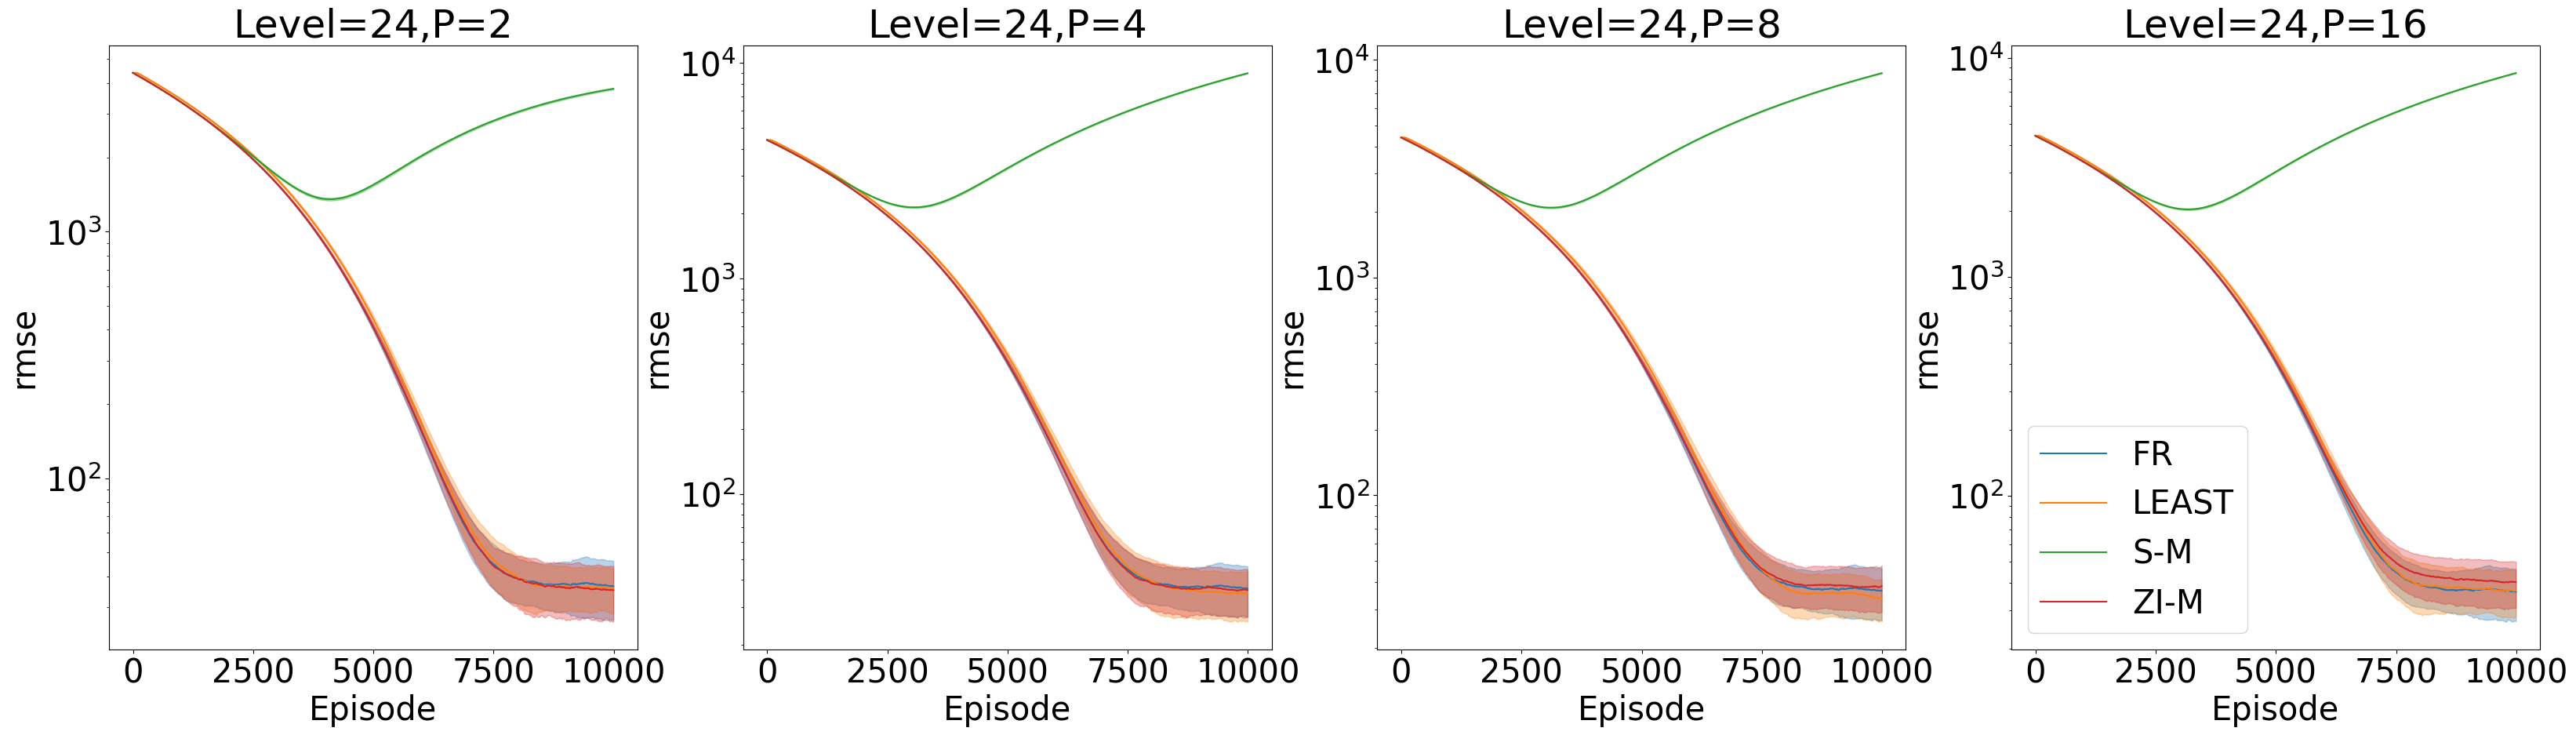

In [43]:
df_proposed = df_final[df_final["method"] != "SkipMissingReward"]
ax = utils.plot_multiple_configs(
    df_proposed,
    configs=utils.get_configs(df_proposed, level="24"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax, "figures/cpr_v2/abc/_skip_skipmissing_abc_fixed_L24_change_Pxx", format="pdf"
)

In [44]:
df_final["rmse"].apply(lambda x: x["mean"])
# non-convergece to zero is because alpha > 0

0      2317.339873
1        91.800264
2       521.703159
3      2156.150043
4       869.362362
          ...     
444      18.810962
445       1.811690
446     992.115454
447      18.577122
448      18.045605
Name: rmse, Length: 52000, dtype: float64

## Complexity ~ Error

In [45]:
df_final

,config,method,episode,rmse,mean_error,pearson_corr,spearman_corr,qtable,L,P
0,L24-P16,S-M,2260,"{'min': 2283.854745819007, 'max': 2341.9700040...","{'min': 1019.5594, 'max': 1089.3324, 'mean': 1...","{'min': 0.38118094, 'max': 0.47569397, 'mean':...","{'min': -0.20606781869450203, 'max': 0.2379181...","{'min': [[-2987.564453125, -2956.5009765625, -...",24,16
1,L24-P8,ZI-M,6540,"{'min': 58.67342915717897, 'max': 124.96059925...","{'min': 16.829405, 'max': 83.41621, 'mean': 47...","{'min': 0.99931777, 'max': 0.9998484, 'mean': ...","{'min': 0.9983393892926191, 'max': 0.998732082...","{'min': [[-7075.61083984375, -7303.00537109375...",24,8
2,L24-P4,LEAST,4800,"{'min': 483.8966024627575, 'max': 563.67984596...","{'min': 241.20935, 'max': 314.96686, 'mean': 2...","{'min': 0.98798305, 'max': 0.991695, 'mean': 0...","{'min': 0.998919483521123, 'max': 0.9994235171...","{'min': [[-5965.43505859375, -6010.96240234375...",24,4
3,L24-P1,FR,2270,"{'min': 2131.5995167948413, 'max': 2189.736627...","{'min': 1481.259, 'max': 1532.3433, 'mean': 15...","{'min': 0.8423263999999999, 'max': 0.86484796,...","{'min': 0.750956508211658, 'max': 0.9613203658...","{'min': [[-2921.563720703125, -2923.6315917968...",24,1
4,L24-P2,LEAST,4110,"{'min': 830.0895283040257, 'max': 915.88130371...","{'min': 455.95697, 'max': 530.4797, 'mean': 49...","{'min': 0.9694518999999999, 'max': 0.97751653,...","{'min': 0.9891861679667531, 'max': 0.999393570...","{'min': [[-5187.486328125, -5196.77001953125, ...",24,2
...,...,...,...,...,...,...,...,...,...,...
444,L16-P4,ZI-M,5380,"{'min': 11.715082108278667, 'max': 33.97177029...","{'min': -8.818337, 'max': 25.629955, 'mean': 7...","{'min': 0.9996653999999999, 'max': 0.99989814,...","{'min': 0.99665694068023, 'max': 0.99779197045...","{'min': [[-2191.7080078125, -2324.75146484375,...",16,4
445,L2-P16,ZI-M,1310,"{'min': 0.572787180630788, 'max': 3.1202382238...","{'min': -0.26663329999999996, 'max': 1.9272976...","{'min': 0.584616, 'max': 0.996091, 'mean': 0.9...","{'min': 0.5882352941176471, 'max': 1.0, 'mean'...","{'min': [[-7.355101108551025, -10.164328575134...",2,16
446,L16-P16,ZI-M,520,"{'min': 983.076834484467, 'max': 1003.70684838...","{'min': 765.1679, 'max': 786.257, 'mean': 773....","{'min': 0.6441498999999999, 'max': 0.7424543, ...","{'min': 0.326426332213612, 'max': 0.7852956683...","{'min': [[-488.1918640136719, -483.63348388671...",16,16
447,L16-P4,ZI-M,9500,"{'min': 11.488698298703506, 'max': 33.59619177...","{'min': -13.686269, 'max': 22.721277, 'mean': ...","{'min': 0.9996231, 'max': 0.9998792400000001, ...","{'min': 0.996431485475436, 'max': 0.9978718937...","{'min': [[-2203.994140625, -2329.649658203125,...",16,4


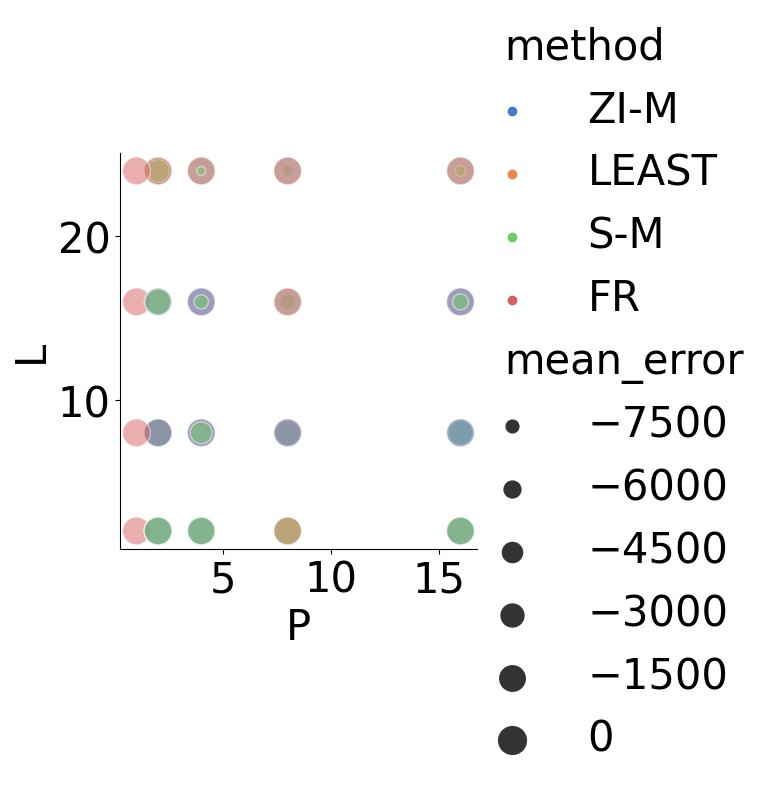

In [46]:
import copy


def scatter_plot_data(
    df: pd.DataFrame, value: str, excluded_methods: Sequence[str]
) -> pd.DataFrame:
    _df = copy.deepcopy(df)
    _df = _df[_df["episode"] == _df["episode"].max()]
    for method in excluded_methods:
        _df = _df[_df["method"] != method]
    _df[value] = _df[value].map(lambda x: x["mean"])
    for col in ("L", "P"):
        _df[col] = _df[col].astype(int)
    return _df[["L", "P", "method", value]]


_df = scatter_plot_data(
    df_final, value="mean_error", excluded_methods=["SkipMissingReward"]
)

sns.relplot(
    x="P",
    y="L",
    hue="method",
    size="mean_error",
    sizes=(40, 400),
    alpha=0.5,
    palette="muted",
    height=6,
    data=_df,
)

In [47]:
_df[_df["method"] == "ConsistentRewards"]

,L,P,method,mean_error


## Mean Error

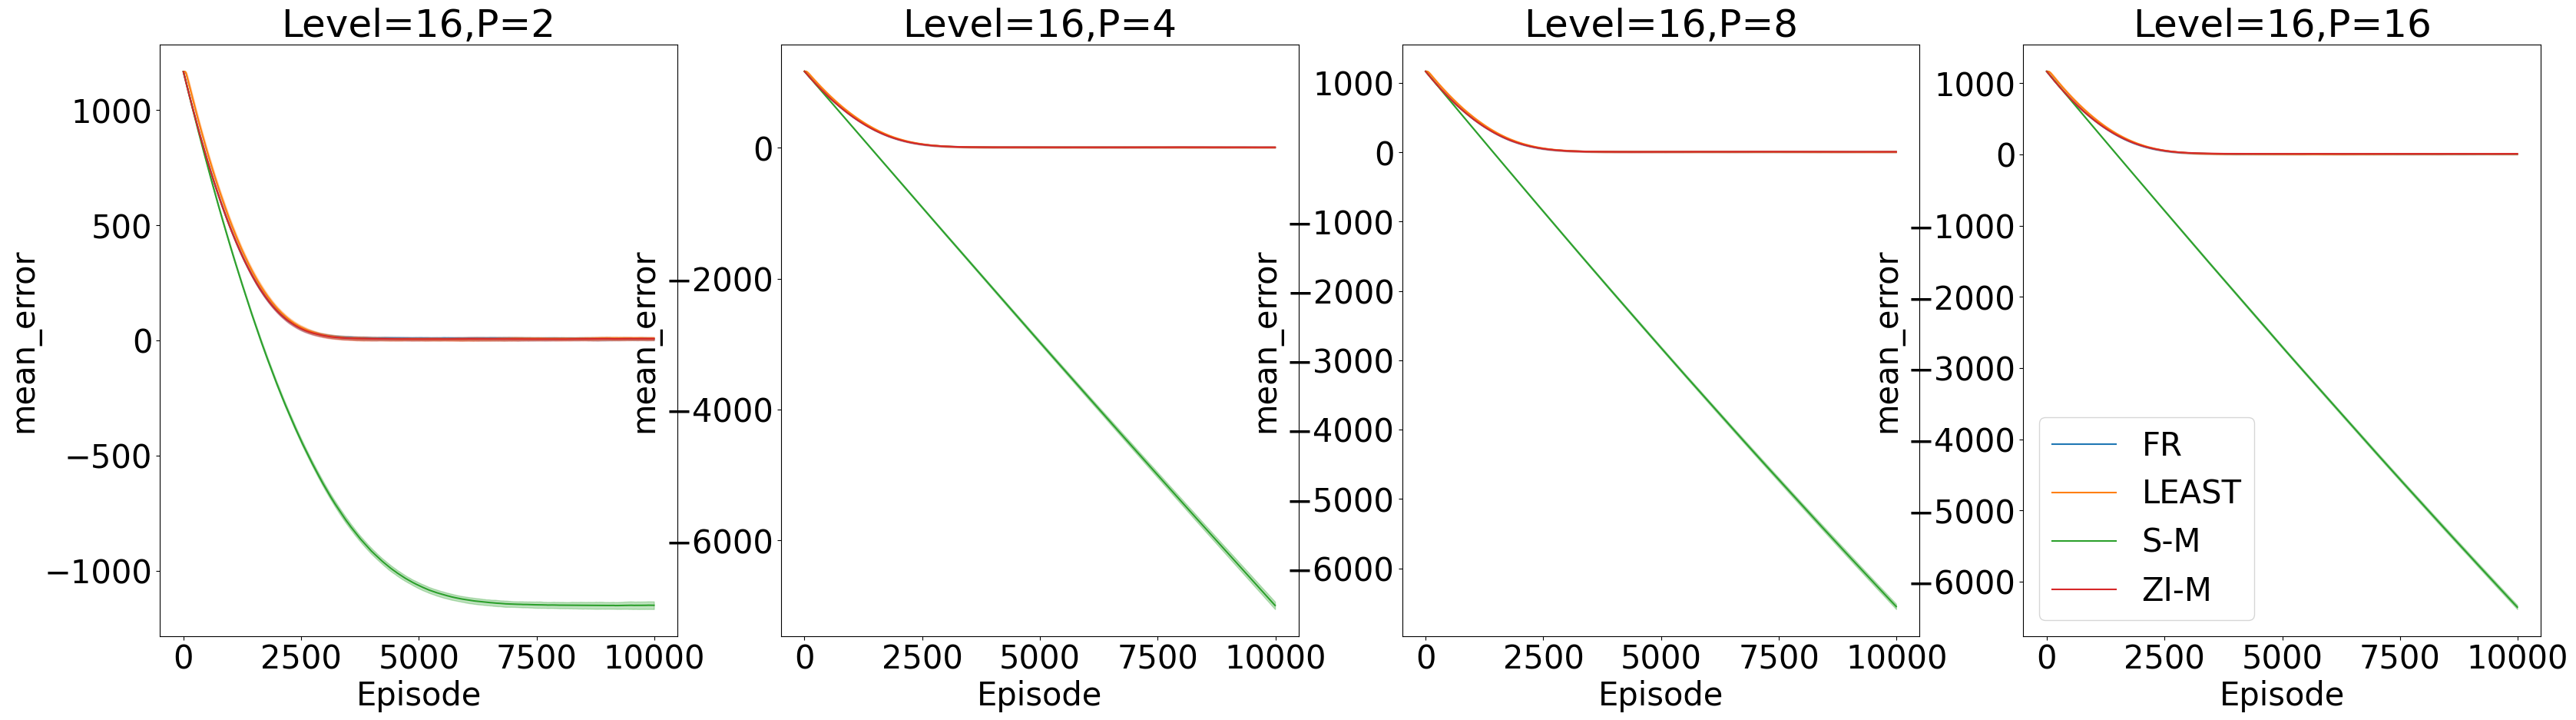

In [48]:
# One plot with mean error
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="16"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=False,
    metric="mean_error",
)
utils.export_figure(
    ax, "figures/cpr_v2/abc/abc_fixed_L16_change_Pxx_mean_error", format="pdf"
)

## Correlations

In [49]:
import imp

imp.reload(utils)

<module 'exps.utils' from '/Users/guilherme/Code/rl-daaf/notebooks/daaf/onpolicy_eval/exps/utils.py'>

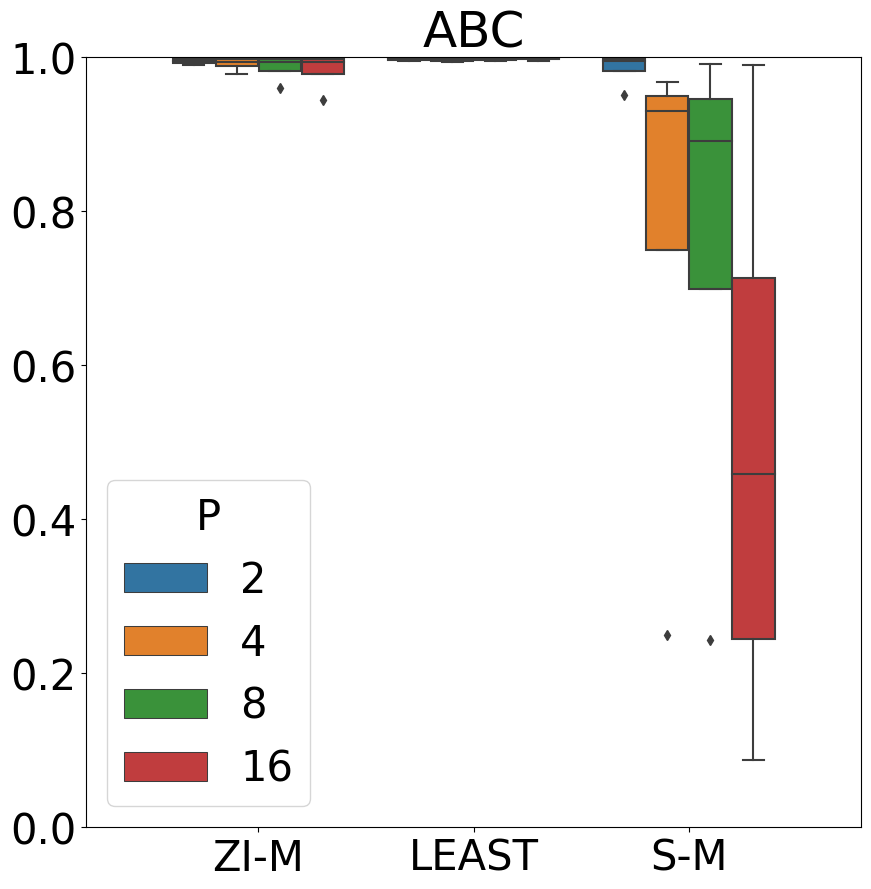

In [50]:
ax = utils.boxplot_corr(
    utils.final_episode_metrics(df_final, metric="spearman_corr"),
    metric="spearman_corr (mean)",
    title="ABC",
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_spearman_corr", format="pdf")

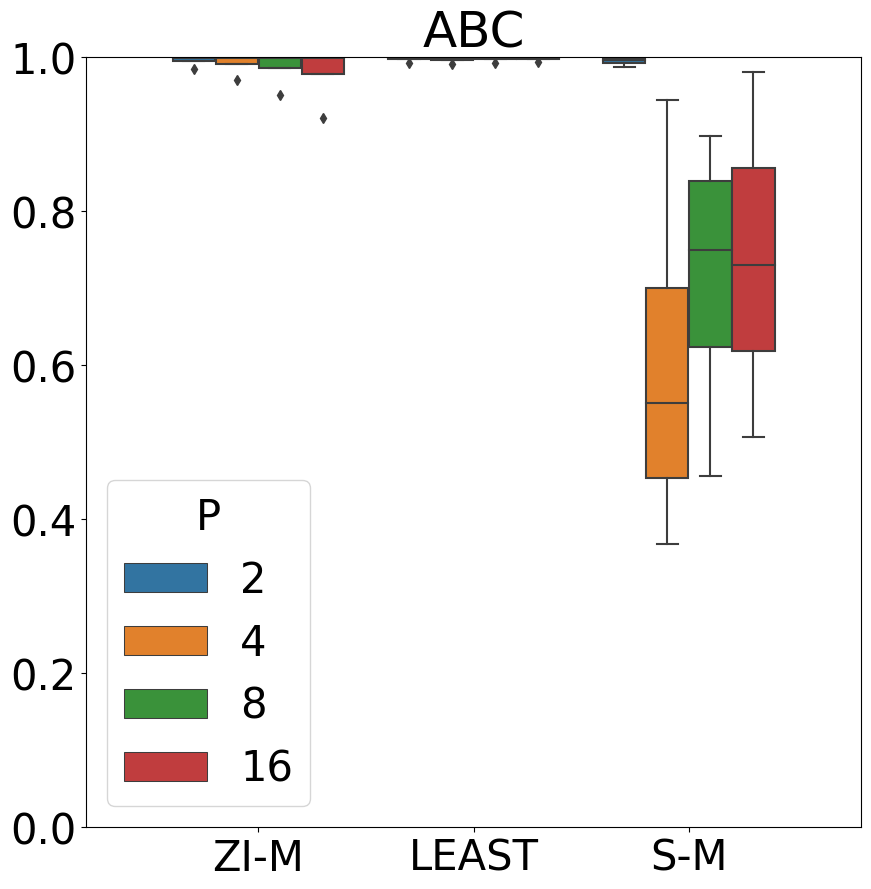

In [51]:
ax = utils.boxplot_corr(
    utils.final_episode_metrics(df_final, metric="pearson_corr"),
    metric="pearson_corr (mean)",
    title="ABC",
)
utils.export_figure(ax, "figures/cpr_v2/abc/abc_pearson_corr", format="pdf")

## Q-Tables

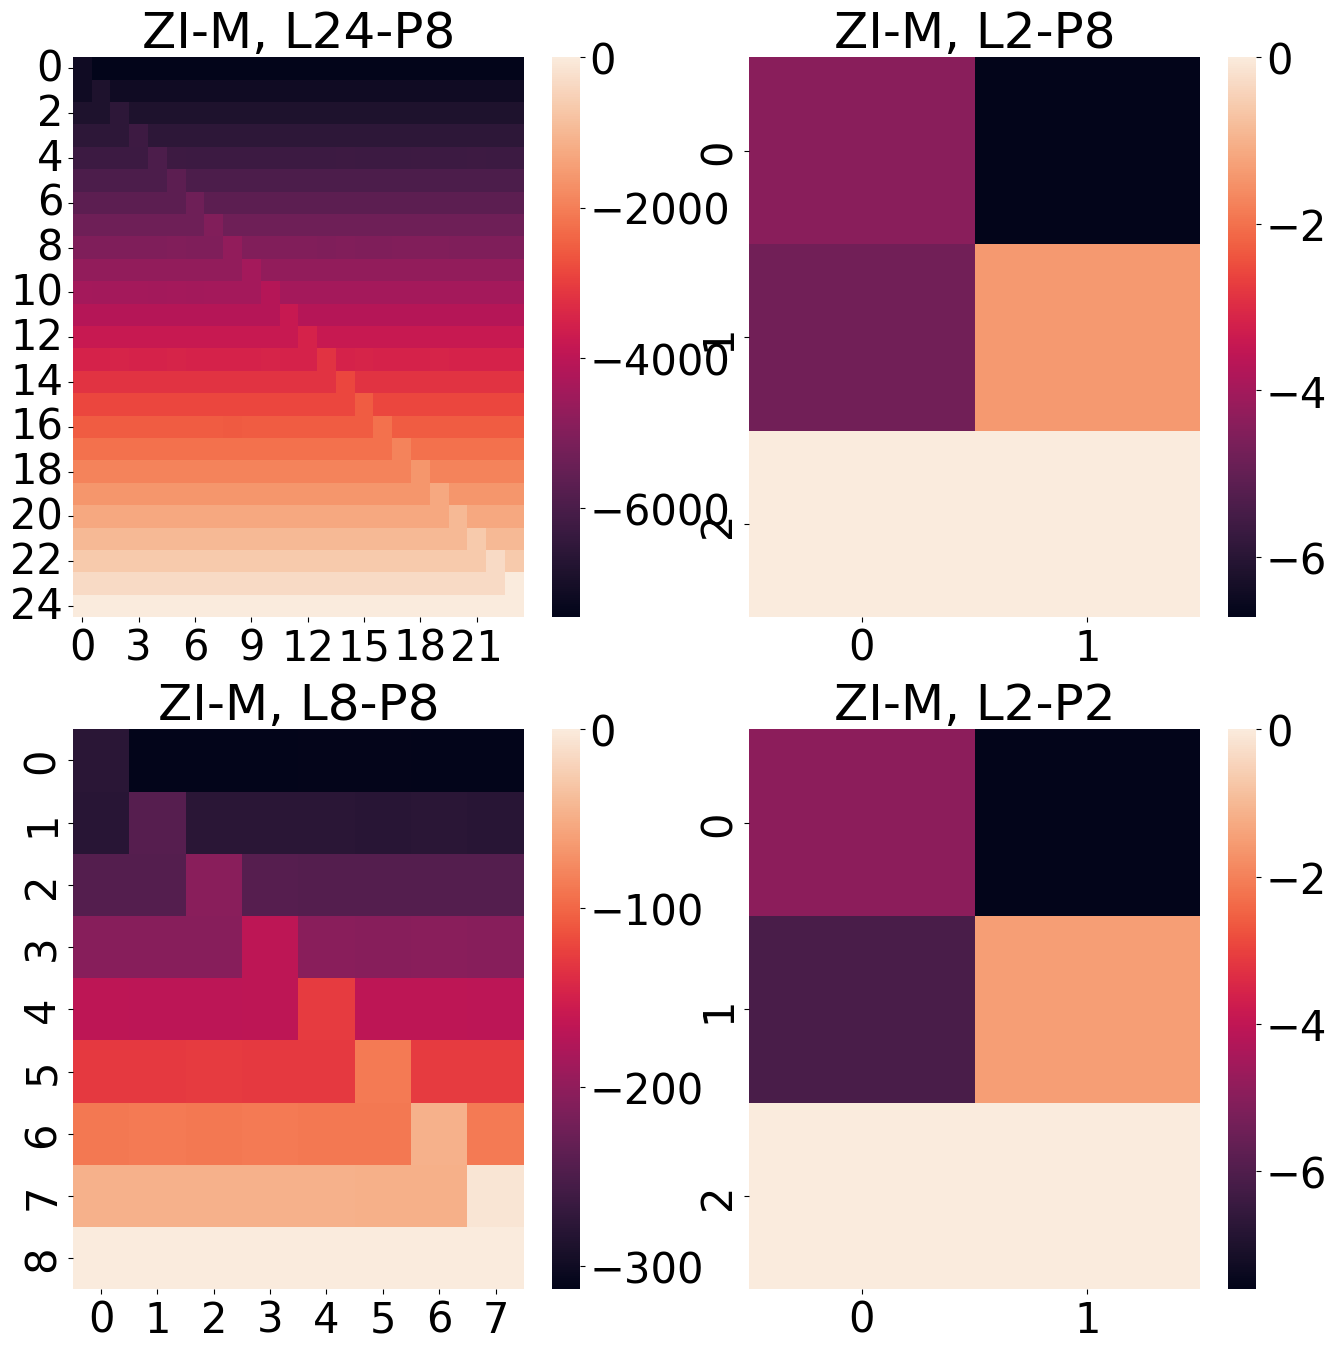

In [52]:
_ = utils.qtable_sample_heatmaps(df_final, method="ZI-M", figsize=(16, 16))

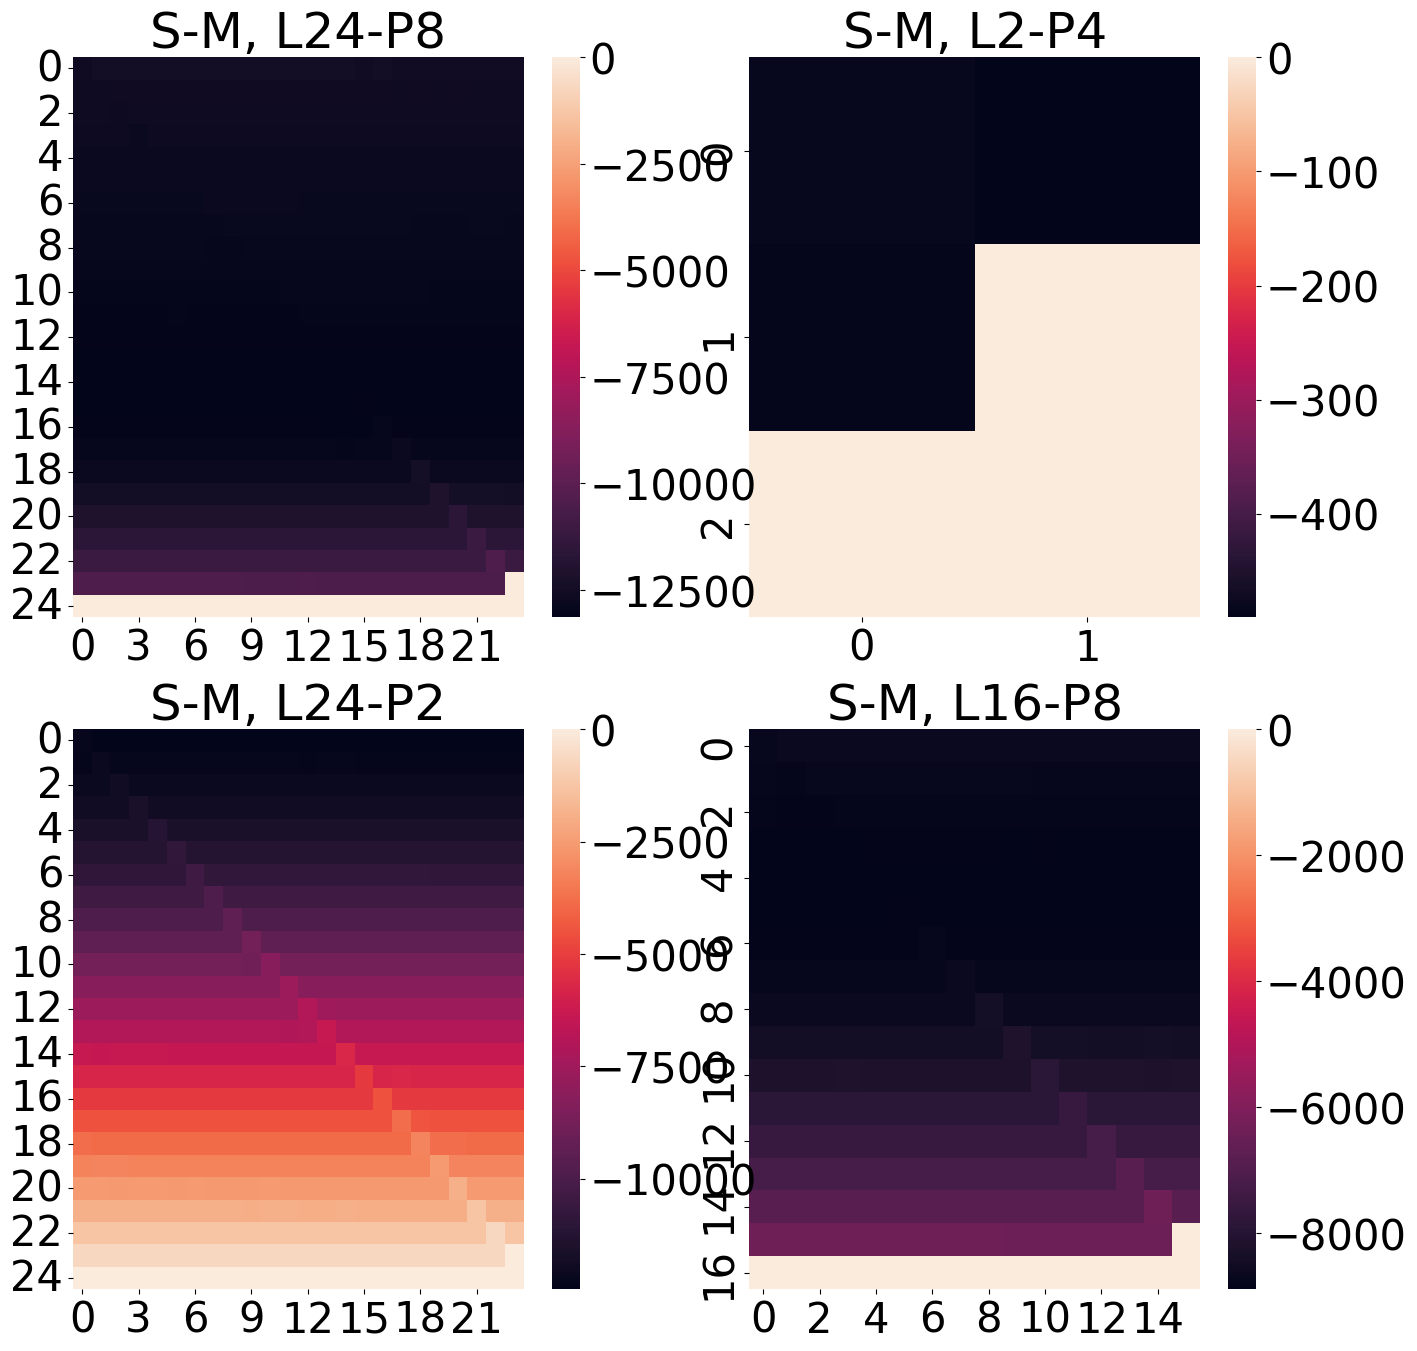

In [53]:
_ = utils.qtable_sample_heatmaps(df_final, method="S-M", figsize=(16, 16))

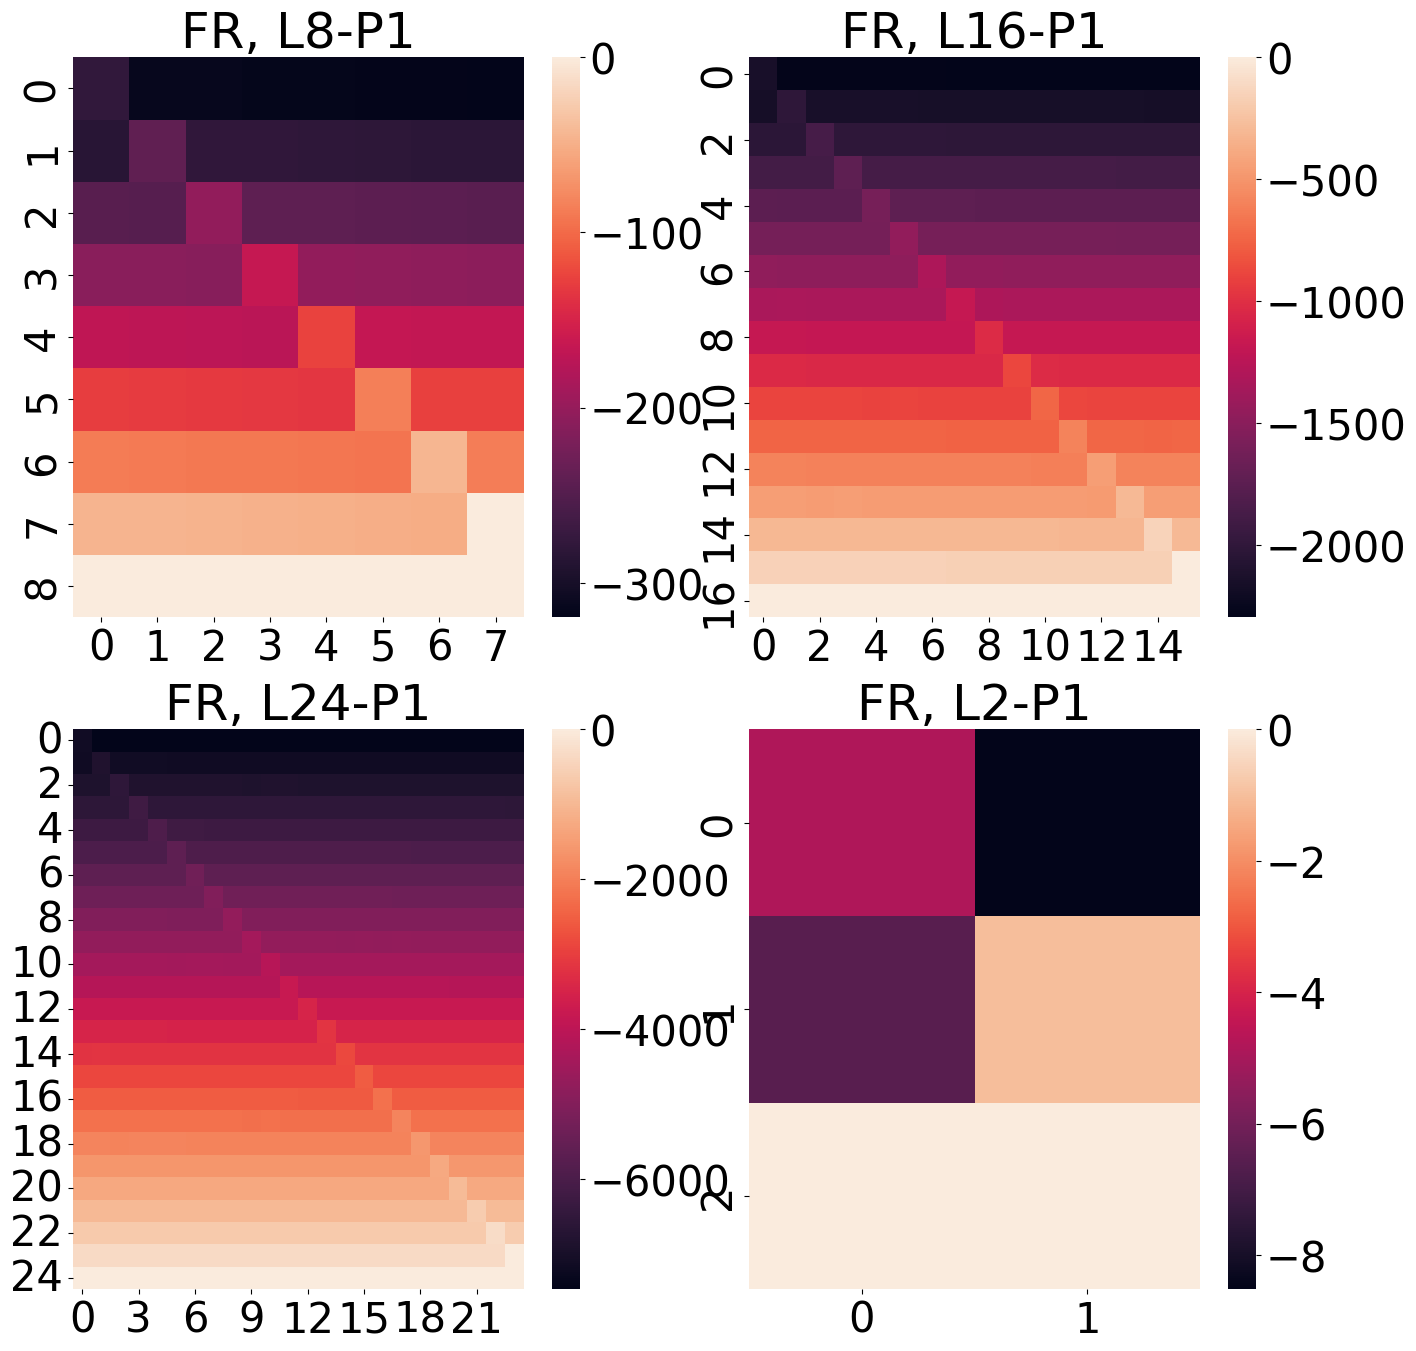

In [54]:
_ = utils.qtable_sample_heatmaps(df_final, method="FR", figsize=(16, 16))

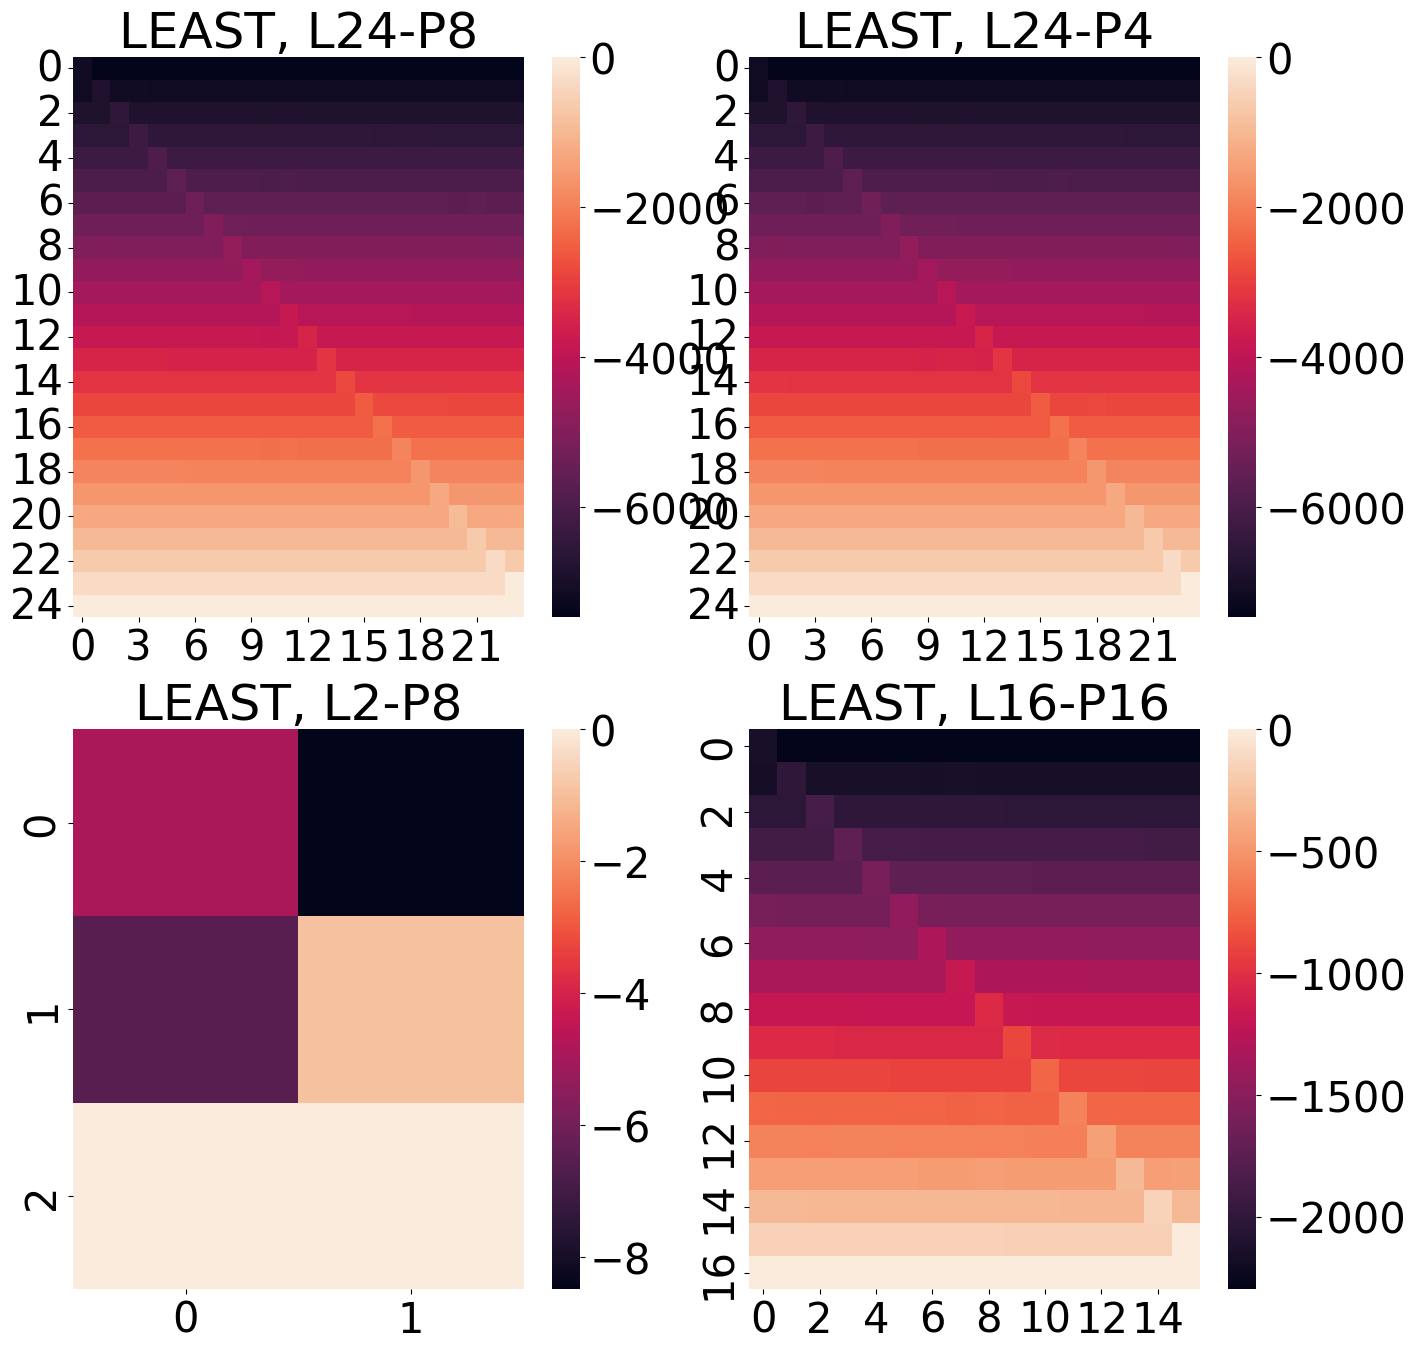

In [55]:
_ = utils.qtable_sample_heatmaps(df_final, method="LEAST", figsize=(16, 16))

In [56]:
print(
    utils.df_final_print(
        utils.combine_table_config_comparisons(
            df_final, configs=["L2-P2", "L8-P2", "L16-P2", "L24-P2"]
        ),
        metric="rmse",
    ).to_latex(index=False)
)

\begin{tabular}{lrll}
\toprule
Level &  P & Method &      rmse ± std \\
\midrule
    2 &  2 &     FR &     0.547±0.239 \\
    2 &  2 &  LEAST &      0.66±0.363 \\
    2 &  2 &    S-M &     2.295±0.693 \\
    2 &  2 &   ZI-M &     0.868±0.261 \\
    8 &  2 &     FR &     6.322±1.652 \\
    8 &  2 &  LEAST &     6.147±1.638 \\
    8 &  2 &    S-M &   185.377±6.437 \\
    8 &  2 &   ZI-M &     6.111±1.704 \\
   16 &  2 &     FR &    17.593±3.736 \\
   16 &  2 &  LEAST &    18.578±4.647 \\
   16 &  2 &    S-M &  1344.72±17.973 \\
   16 &  2 &   ZI-M &     18.411±3.79 \\
   24 &  2 &     FR &    36.421±9.763 \\
   24 &  2 &  LEAST &     35.84±7.414 \\
   24 &  2 &    S-M & 3791.951±30.037 \\
   24 &  2 &   ZI-M &    35.215±8.889 \\
\bottomrule
\end{tabular}



/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_30776/372597573.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.df_final_print(utils.combine_table_config_comparisons(df_final, configs=["L2-P2", "L8-P2", "L16-P2", "L24-P2"]), metric="rmse").to_latex(index=False))


## Results Tables

In [57]:
experiments

{'16': [1, 2, 4, 8, 16],
 '2': [1, 2, 4, 8, 16],
 '24': [1, 2, 4, 8, 16],
 '8': [1, 2, 4, 8, 16]}

In [58]:
df_rmse_results = utils.metric_results_table(
    df_final,
    metric="rmse",
    experiments=experiments,
    level_transform_fn=lambda x: int(x),
)

In [59]:
df_rmse_results

method,Level/Map,P,FR,S-M,ZI-M,LEAST
5,2,2,0.547±0.239,2.295±0.693,0.868±0.261,0.66±0.363
6,2,4,0.547±0.239,338.649±17.374,1.319±0.399,0.628±0.348
7,2,8,0.547±0.239,30.896±4.624,1.537±0.467,0.595±0.252
4,2,16,0.547±0.239,4.738±0.458,1.753±0.539,0.553±0.243
13,8,2,6.322±1.652,185.377±6.437,6.111±1.704,6.147±1.638
14,8,4,6.322±1.652,3852.374±47.991,6.494±1.366,5.854±1.429
15,8,8,6.322±1.652,2687.982±41.446,7.736±1.761,5.927±1.436
12,8,16,6.322±1.652,2498.938±34.716,9.369±1.825,5.927±1.301
1,16,2,17.593±3.736,1344.72±17.973,18.411±3.79,18.578±4.647
2,16,4,17.593±3.736,7238.37±59.674,18.806±4.431,17.406±4.026


In [60]:
print(
    utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).to_latex(
        index=False, col_space=3, escape=False
    )
)

\begin{tabular}{rrllll}
\toprule
 Level/Map &   P &           FR &             S-M &                  ZI-M &                 LEAST \\
\midrule
         2 &   2 &  0.547±0.239 &     2.295±0.693 &           0.868±0.261 &   \textbf{0.66±0.363} \\
         2 &   4 &  0.547±0.239 &  338.649±17.374 &           1.319±0.399 &  \textbf{0.628±0.348} \\
         2 &   8 &  0.547±0.239 &    30.896±4.624 &           1.537±0.467 &  \textbf{0.595±0.252} \\
         2 &  16 &  0.547±0.239 &     4.738±0.458 &           1.753±0.539 &  \textbf{0.553±0.243} \\
         8 &   2 &  6.322±1.652 &   185.377±6.437 &  \textbf{6.111±1.704} &           6.147±1.638 \\
         8 &   4 &  6.322±1.652 & 3852.374±47.991 &           6.494±1.366 &  \textbf{5.854±1.429} \\
         8 &   8 &  6.322±1.652 & 2687.982±41.446 &           7.736±1.761 &  \textbf{5.927±1.436} \\
         8 &  16 &  6.322±1.652 & 2498.938±34.716 &           9.369±1.825 &  \textbf{5.927±1.301} \\
        16 &   2 & 17.593±3.736 &  1344.72±17.973

/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_30776/1089978551.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).to_latex(index=False, col_space=3, escape=False))


In [61]:
print(
    utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"])
    .drop(["FR"], axis=1)
    .to_latex(index=False, col_space=3, escape=False)
)

\begin{tabular}{rrlll}
\toprule
 Level/Map &   P &             S-M &                  ZI-M &                 LEAST \\
\midrule
         2 &   2 &     2.295±0.693 &           0.868±0.261 &   \textbf{0.66±0.363} \\
         2 &   4 &  338.649±17.374 &           1.319±0.399 &  \textbf{0.628±0.348} \\
         2 &   8 &    30.896±4.624 &           1.537±0.467 &  \textbf{0.595±0.252} \\
         2 &  16 &     4.738±0.458 &           1.753±0.539 &  \textbf{0.553±0.243} \\
         8 &   2 &   185.377±6.437 &  \textbf{6.111±1.704} &           6.147±1.638 \\
         8 &   4 & 3852.374±47.991 &           6.494±1.366 &  \textbf{5.854±1.429} \\
         8 &   8 & 2687.982±41.446 &           7.736±1.761 &  \textbf{5.927±1.436} \\
         8 &  16 & 2498.938±34.716 &           9.369±1.825 &  \textbf{5.927±1.301} \\
        16 &   2 &  1344.72±17.973 &  \textbf{18.411±3.79} &          18.578±4.647 \\
        16 &   4 &  7238.37±59.674 &          18.806±4.431 & \textbf{17.406±4.026} \\
        16 & 

/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_30776/2678292717.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).drop(["FR"], axis=1).to_latex(index=False, col_space=3, escape=False))
